In [215]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil 
import seaborn as sns
import math  
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
from trimesh import load_mesh
from scipy.optimize import minimize
from scipy.linalg import null_space
from joblib import Parallel, delayed

%matplotlib inline

In [216]:
criteria_name = 'waveform_all'
waveform_version = '_raw' # 'wf_2D' for 'wf_2D_raw'

target_folder = '/root/capsule/scratch/manuscript/F_waveform_space'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [217]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

Applying bounds for isi_violations: [0.0, 0.5]
 - isi_violations: 18300 -> 11635 units passed
Applying items for qc_pass: [True]
 - qc_pass: 11635 -> 8492 units passed
Applying bounds for peak: ['NaN', -50]
 - peak: 8492 -> 6641 units passed
Applying items for probe: ['2']
 - probe: 6641 -> 5466 units passed
Applying conditional bounds for y_loc
 - y_loc: 5466 -> 3486 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 308
Number of non-opto rows after filtering: 3486


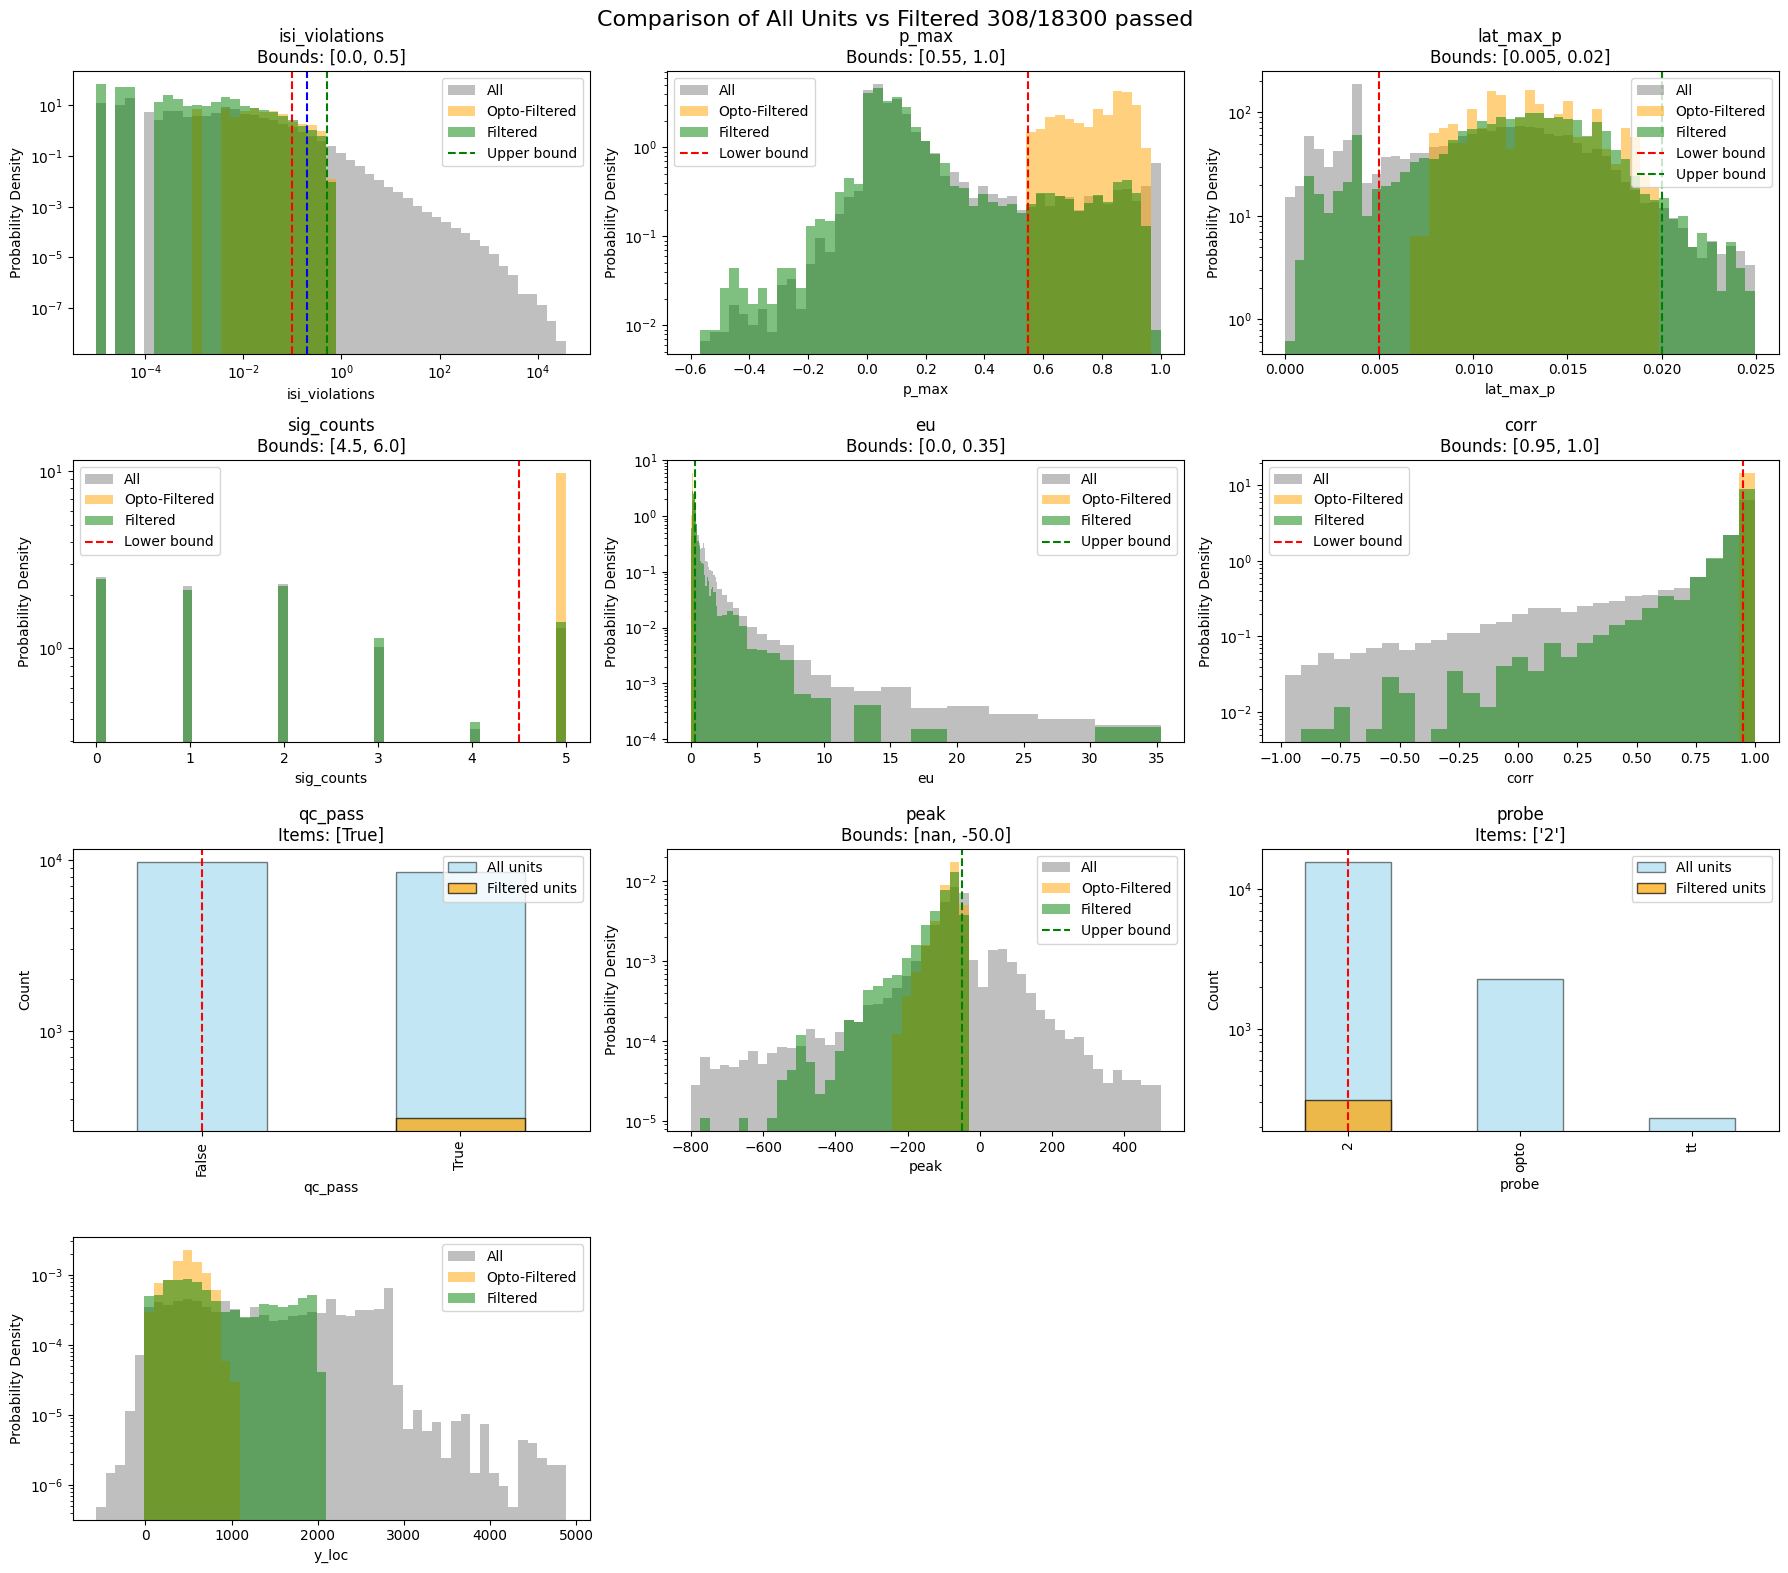

In [218]:
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints)
fig.savefig(os.path.join(target_folder, 'quality_metrics.pdf'))

In [219]:
antidromic_file = '/root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL_S1/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

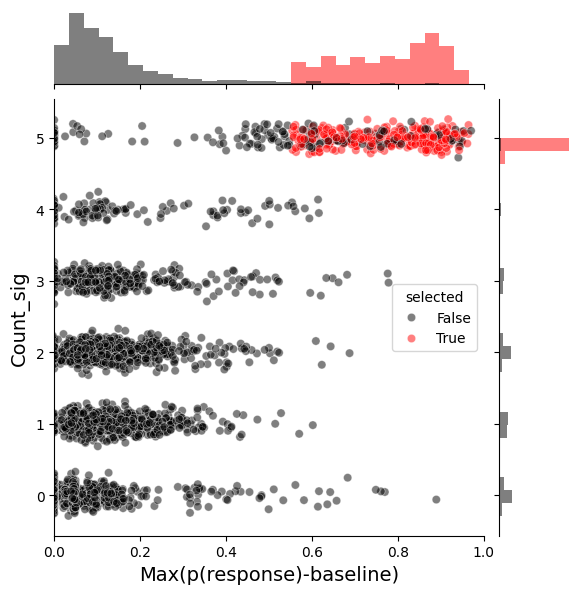

In [220]:

# opto tagged vs not
# Define color palette for groups
palette = {True: "r", False: "k"}
x_col = 'p_max'
y_col = 'sig_counts'

combined_tagged_units_plot = combined_tagged_units.copy()
combined_tagged_units_plot[y_col] = combined_tagged_units_plot[y_col]  + np.random.normal(0, 0.1, size=len(combined_tagged_units_plot[y_col]))  # add jitter to y-axis for better visibility

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units_plot[combined_tagged_units['selected_qc_only']], x=x_col, y=y_col, hue='selected', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Count_sig', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(0, 1, 30)
y_bins = np.linspace(combined_tagged_units_plot[combined_tagged_units['selected_qc_only']][y_col].min(), combined_tagged_units[combined_tagged_units['selected_qc_only']][y_col].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units_plot[combined_tagged_units['selected_qc_only'] & (combined_tagged_units['selected'] == qc_val)]
    # Horizontal histogram for x-axis (default orientation)
    ax = g.ax_marg_x
    ax.hist(subset[x_col], bins=p_max_bins, color=color, alpha=0.5, edgecolor='none', density='True')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    ax = g.ax_marg_y
    ax.hist(subset[y_col], bins=y_bins, color=color, alpha=0.5, edgecolor='none', density='True',  orientation='horizontal')
    # sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')

plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
# Show plot
plt.show()



In [221]:
# Extract waveform feature fix
wf_norm = []
wf_2D_norm = []

half_w = []
trough_w = []
pre_half = []
post_half = []
post_w = []
pre_w = []

trough_post_ratio_1D = []
trough_pre_ratio_1D = []

post_slope = []
post_trough_slope = []
post_space = []
post_space_raw = []
pre_slope = []
pre_space = []
pre_space_raw = []

symmetry_inte = []
symmetry_half = []
symmetry_slope = []
symmetry_inte_div = []
symmetry_half_div = []
symmetry_slope_div = []
symmetry_space_raw_div = []
symmetry_trough_dis = []

trough_sum = []
slope_sum = []


# wf_norm = combined_tagged_units_filtered['wf']/np.abs(combined_tagged_units_filtered['peak'])
# wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])

wf_norm = combined_tagged_units_filtered[f'wf{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
wf_2D_norm = combined_tagged_units_filtered[f'wf_2d{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
for rows in combined_tagged_units_filtered.iterrows():
    print(f'Processing unit {rows[1]["unit"]} of session {rows[1]["session"]}')
    # wf = rows[1]['wf']
    # peak = rows[1]['peak']
    # print(rows[1]['session'])
    # print(rows[1]['unit'])
    if rows[0]==109:
        print(rows[0])
    wf = rows[1][f'wf{waveform_version}']
    wf_bl = np.nanmean(wf[:5])
    peak = rows[1]['peak_raw'] - wf_bl
    wf = wf - wf_bl
    peak_ind = np.argmin(wf)

    if np.abs(wf[0]-wf[-1])>50:
        half_w.append(np.nan)  # half width in samples
        trough_w.append(np.nan)  # trough width in samples
        post_w.append(np.nan)  # post trough width in samples
        pre_w.append(np.nan)
        pre_half.append(np.nan)
        post_half.append(np.nan)
        trough_post_ratio_1D.append(np.nan)
        trough_pre_ratio_1D.append(np.nan)
        post_slope.append(np.nan)
        post_trough_slope.append(np.nan)
        post_space.append(np.nan)
        pre_slope.append(np.nan)
        pre_space.append(np.nan)
        symmetry_inte.append(np.nan)
        symmetry_half.append(np.nan)
        symmetry_slope.append(np.nan)
        symmetry_inte_div.append(np.nan)
        symmetry_half_div.append(np.nan)
        symmetry_slope_div.append(np.nan)
        symmetry_space_raw_div.append(np.nan)
        symmetry_trough_dis.append(np.nan)
        post_space_raw.append(np.nan)
        pre_space_raw.append(np.nan)
        continue

    if peak<0:
        curr_trough_loc = np.argmax(wf[peak_ind:])+1
        post_trough = np.max(wf[peak_ind:])
        post_trough_ind = np.argmax(wf[peak_ind:])+1
        pre_trough = np.max(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmax(wf[:peak_ind])  
    else:
        curr_trough_loc = np.argmin(wf[peak_ind:])+1
        post_trough = np.min(wf[peak_ind:])
        post_trough_ind = np.argmin(wf[peak_ind:])+1
        pre_trough = np.min(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmin(wf[:peak_ind])  
    curr_trough_post = post_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_pre = pre_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_post = ((peak - post_trough)/peak)/post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_slope = (post_trough/peak)/post_trough_ind
    curr_trough_loc_inte_post = ((post_trough)/peak)*post_trough_ind
    curr_trough_loc_slope_pre = ((peak - pre_trough)/peak)/pre_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_pre = ((pre_trough)/peak)*pre_trough_ind # positive if same sign, negative if opposite sign
    pre_peak_wf = wf[:peak_ind]
    post_peak_wf = wf[peak_ind:]
    curr_pre_space_raw = np.sum(pre_peak_wf[pre_peak_wf>0])
    curr_post_space_raw = np.sum(post_peak_wf[post_peak_wf>0])

    curr_symmetry_inte = curr_trough_loc_inte_post - curr_trough_loc_inte_pre  # positive if same sign, negative if opposite sign
    curr_symmetry_slope = curr_trough_loc_slope_post - curr_trough_loc_slope_pre  # positive if same sign, negative if opposite sign
    
    curr_trough_sum = (curr_pre_space_raw + curr_post_space_raw)/peak
    curr_slope_sum = curr_trough_loc_slope_post + curr_trough_loc_slope_pre
    

    # find samples where the waveform crosses the half peak threshold to infer half width
    half_peak = peak / 2
    wf_half_crossings = np.where(np.diff(np.sign(wf - half_peak))!=0)[0]
    if len(wf_half_crossings) < 2:
        post_crossing = np.nan
        pre_crossing = np.nan
    else: 
        if np.all(wf_half_crossings < peak_ind) or np.all(wf_half_crossings > peak_ind):
            post_crossing = np.nan
            pre_crossing = np.nan
        else:
            post_crossing = np.min(wf_half_crossings[wf_half_crossings > peak_ind]) - peak_ind
            pre_crossing = peak_ind - np.max(wf_half_crossings[wf_half_crossings < peak_ind])

    half_w.append(post_crossing + pre_crossing)  # half width in samples
    trough_w.append(post_trough_ind + pre_trough_ind)  # trough width in samples
    post_w.append(post_trough_ind)  # post trough width in samples
    pre_w.append(pre_trough_ind)
    pre_half.append(pre_crossing)
    post_half.append(post_crossing)

    trough_post_ratio_1D.append(curr_trough_post)
    trough_pre_ratio_1D.append(curr_trough_pre)

    post_slope.append(curr_trough_loc_slope_post)
    post_trough_slope.append(curr_trough_slope)
    post_space.append(curr_trough_loc_inte_post)
    pre_slope.append(curr_trough_loc_slope_pre)
    pre_space.append(curr_trough_loc_inte_pre)
    post_space_raw.append(curr_post_space_raw)
    pre_space_raw.append(curr_pre_space_raw)

    symmetry_inte.append(curr_trough_loc_inte_post - curr_trough_loc_inte_pre)
    symmetry_half.append(post_crossing - pre_crossing)
    symmetry_slope.append(curr_trough_loc_slope_post - curr_trough_loc_slope_pre)

    symmetry_inte_div.append(curr_trough_loc_inte_post/curr_trough_loc_inte_pre)
    symmetry_half_div.append(post_crossing/pre_crossing)
    symmetry_slope_div.append(curr_trough_loc_slope_pre/curr_trough_loc_slope_post)
    symmetry_space_raw_div.append(curr_post_space_raw/curr_pre_space_raw)
    symmetry_trough_dis.append(post_trough_ind - pre_trough_ind)

    trough_sum.append(curr_trough_sum)
    slope_sum.append(curr_slope_sum)

wf_features = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
                            'session': combined_tagged_units_filtered['session'],
                            'amp': combined_tagged_units_filtered['amp'],
                            'peak': combined_tagged_units_filtered['peak'],
                            'half_w': half_w,
                            'trough_w': trough_w,
                            'pre_half': pre_half,
                            'post_half': post_half,
                            'post_w': post_w,
                            'pre_w':pre_w,
                            'trough_post_ratio_1D': trough_post_ratio_1D,
                            'trough_pre_ratio_1D': trough_pre_ratio_1D,
                            'post_slope': post_slope,
                            'post_trough_slope': post_trough_slope,
                            'post_space': post_space,
                            'pre_slope': pre_slope,
                            'pre_space': pre_space,
                            'symmetry_inte': symmetry_inte,
                            'symmetry_half': symmetry_half,
                            'symmetry_slope': symmetry_slope,
                            'symmetry_inte_div': symmetry_inte_div,
                            'symmetry_half_div': symmetry_half_div,
                            'symmetry_slope_div': symmetry_slope_div,
                            'symmetry_space_raw_div': symmetry_space_raw_div,
                            'symmetry_trough_dis': symmetry_trough_dis,
                            'trough_sum': trough_sum,
                            'slope_sum': slope_sum,
                            'y_loc': combined_tagged_units_filtered['y_loc'],
                            'probe': combined_tagged_units_filtered['probe'],
                            })
wf_features['symmetry_inte_div_log'] = np.log(wf_features['symmetry_inte_div'] + 1e-6)
wf_features['symmetry_slope_div_log'] = np.log(wf_features['symmetry_slope_div'] + 1e-6)
wf_features['symmetry_half_div_log'] = np.log(wf_features['symmetry_half_div'] + 1e-6)
wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)
combined_features = wf_features.merge(combined_tagged_units_filtered[['session', 'unit', 'x_ccf', 'y_ccf', 'z_ccf', 'isi_violations']], on=['session', 'unit'], how='left')
combined_features = combined_features.merge(antidromic_df[['session', 'unit', 'tier_1']], on=['session', 'unit'], how='left')
combined_features['tier_1'] = combined_features['tier_1'].fillna(0)

Processing unit 64 of session ecephys_713854_2024-03-05_12-01-40
Processing unit 65 of session ecephys_713854_2024-03-05_12-01-40
Processing unit 0 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 3 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 11 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 15 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 27 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 141 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 167 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 169 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 17 of session ecephys_713854_2024-03-05_13-31-20
Processing unit 18 of session ecephys_713854_2024-03-05_13-31-20
Processing unit 21 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 32 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 43 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 44 of se

In [222]:
# # Old Extract waveform feature
# wf_norm = []
# wf_2D_norm = []

# half_w = []
# trough_w = []
# pre_half = []
# post_half = []
# post_w = []

# trough_post_ratio_1D = []
# trough_pre_ratio_1D = []

# post_slope = []
# post_space = []
# pre_slope = []
# pre_space = []

# symmetry_inte = []
# symmetry_half = []
# symmetry_slope = []
# symmetry_inte_div = []
# symmetry_half_div = []
# symmetry_slope_div = []
# symmetry_trough_dis = []


# # wf_norm = combined_tagged_units_filtered['wf']/np.abs(combined_tagged_units_filtered['peak'])
# # wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])

# wf_norm = combined_tagged_units_filtered[f'wf{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
# wf_2D_norm = combined_tagged_units_filtered[f'wf_2d{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
# for rows in combined_tagged_units_filtered.iterrows():
#     print(f'Processing unit {rows[1]["unit"]} of session {rows[1]["session"]}')
#     # wf = rows[1]['wf']
#     # peak = rows[1]['peak']
#     # print(rows[1]['session'])
#     # print(rows[1]['unit'])
#     if rows[0]==109:
#         print(rows[0])
#     wf = rows[1][f'wf{waveform_version}']
#     peak = rows[1]['peak_raw']
#     peak_ind = np.argmin(wf)

#     if np.abs(wf[0]-wf[-1])>50:
#         half_w.append(np.nan)  # half width in samples
#         trough_w.append(np.nan)  # trough width in samples
#         post_w.append(np.nan)  # post trough width in samples
#         pre_half.append(np.nan)
#         post_half.append(np.nan)
#         trough_post_ratio_1D.append(np.nan)
#         trough_pre_ratio_1D.append(np.nan)
#         post_slope.append(np.nan)
#         post_space.append(np.nan)
#         pre_slope.append(np.nan)
#         pre_space.append(np.nan)
#         symmetry_inte.append(np.nan)
#         symmetry_half.append(np.nan)
#         symmetry_slope.append(np.nan)
#         symmetry_inte_div.append(np.nan)
#         symmetry_half_div.append(np.nan)
#         symmetry_slope_div.append(np.nan)
#         continue

#     if peak<0:
#         curr_trough_loc = np.argmax(wf[peak_ind:])+1
#         post_trough = np.max(wf[peak_ind:])
#         post_trough_ind = np.argmax(wf[peak_ind:])+1
#         pre_trough = np.max(wf[:peak_ind])
#         pre_trough_ind = peak_ind - np.argmax(wf[:peak_ind])  
#     else:
#         curr_trough_loc = np.argmin(wf[peak_ind:])+1
#         post_trough = np.min(wf[peak_ind:])
#         post_trough_ind = np.argmin(wf[peak_ind:])+1
#         pre_trough = np.min(wf[:peak_ind])
#         pre_trough_ind = peak_ind - np.argmin(wf[:peak_ind])  
#     curr_trough_post = post_trough/peak # positive if same sign, negative if opposite sign
#     curr_trough_pre = pre_trough/peak # positive if same sign, negative if opposite sign
#     curr_trough_loc_slope_post = (post_trough/peak)/post_trough_ind # positive if same sign, negative if opposite sign
#     curr_trough_loc_inte_post = ((peak - pre_trough)/peak)*post_trough_ind # positive if same sign, negative if opposite sign
#     curr_trough_loc_slope_pre = ((peak - pre_trough)/peak)/pre_trough_ind # positive if same sign, negative if opposite sign
#     curr_trough_loc_inte_pre = ((peak - post_trough)/peak)*pre_trough_ind # positive if same sign, negative if opposite sign

#     curr_symmetry_inte = curr_trough_loc_inte_post - curr_trough_loc_inte_pre  # positive if same sign, negative if opposite sign
#     curr_symmetry_slope = curr_trough_loc_slope_post - curr_trough_loc_slope_pre  # positive if same sign, negative if opposite sign
    
    

#     # find samples where the waveform crosses the half peak threshold to infer half width
#     half_peak = peak / 2
#     wf_half_crossings = np.where(np.diff(np.sign(wf - half_peak))!=0)[0]
#     if len(wf_half_crossings) < 2:
#         post_crossing = np.nan
#         pre_crossing = np.nan
#     else: 
#         if np.all(wf_half_crossings < peak_ind) or np.all(wf_half_crossings > peak_ind):
#             post_crossing = np.nan
#             pre_crossing = np.nan
#         else:
#             post_crossing = np.min(wf_half_crossings[wf_half_crossings > peak_ind]) - peak_ind
#             pre_crossing = peak_ind - np.max(wf_half_crossings[wf_half_crossings < peak_ind])

#     half_w.append(post_crossing + pre_crossing)  # half width in samples
#     trough_w.append(post_trough_ind + pre_trough_ind)  # trough width in samples
#     post_w.append(post_trough_ind)  # post trough width in samples
#     pre_half.append(pre_crossing)
#     post_half.append(post_crossing)

#     trough_post_ratio_1D.append(curr_trough_post)
#     trough_pre_ratio_1D.append(curr_trough_pre)

#     post_slope.append(curr_trough_loc_slope_post)
#     post_space.append(curr_trough_loc_inte_post)
#     pre_slope.append(curr_trough_loc_slope_pre)
#     pre_space.append(curr_trough_loc_inte_pre)

#     symmetry_inte.append(curr_trough_loc_inte_post - curr_trough_loc_inte_pre)
#     symmetry_half.append(post_crossing - pre_crossing)
#     symmetry_slope.append(curr_trough_loc_slope_post - curr_trough_loc_slope_pre)

#     symmetry_inte_div.append(curr_trough_loc_inte_post/curr_trough_loc_inte_pre)
#     symmetry_half_div.append(post_crossing/pre_crossing)
#     symmetry_slope_div.append(curr_trough_loc_slope_post/curr_trough_loc_slope_pre)

#     symmetry_trough_dis.append(post_trough_ind - pre_trough_ind)


# wf_features = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
#                             'session': combined_tagged_units_filtered['session'],
#                             'amp': combined_tagged_units_filtered['amp'],
#                             'peak': combined_tagged_units_filtered['peak'],
#                             'half_w': half_w,
#                             'trough_w': trough_w,
#                             'pre_half': pre_half,
#                             'post_half': post_half,
#                             'post_w': post_w,
#                             'trough_post_ratio_1D': trough_post_ratio_1D,
#                             'trough_pre_ratio_1D': trough_pre_ratio_1D,
#                             'post_slope': post_slope,
#                             'post_space': post_space,
#                             'pre_slope': pre_slope,
#                             'pre_space': pre_space,
#                             'symmetry_inte': symmetry_inte,
#                             'symmetry_half': symmetry_half,
#                             'symmetry_slope': symmetry_slope,
#                             'symmetry_inte_div': symmetry_inte_div,
#                             'symmetry_half_div': symmetry_half_div,
#                             'symmetry_slope_div': symmetry_slope_div,
#                             'symmetry_trough_dis': symmetry_trough_dis,
#                             'y_loc': combined_tagged_units_filtered['y_loc'],
#                             'probe': combined_tagged_units_filtered['probe'],
#                             })
                            

# wf_features['symmetry_half_div_log'] = np.log(wf_features['symmetry_half_div'] + 1e-6)

# wf_features['symmetry_inte_div_log'] = np.log(wf_features['symmetry_inte_div'])
# wf_features['symmetry_slope_div_log'] = np.log(-wf_features['symmetry_slope_div'] + 1e-6)

# wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)
# combined_features = wf_features.merge(combined_tagged_units_filtered[['session', 'unit', 'x_ccf', 'y_ccf', 'z_ccf', 'isi_violations']], on=['session', 'unit'], how='left')
# combined_features = combined_features.merge(antidromic_df[['session', 'unit', 'tier_1']], on=['session', 'unit'], how='left')
# combined_features['tier_1'] = combined_features['tier_1'].fillna(0)

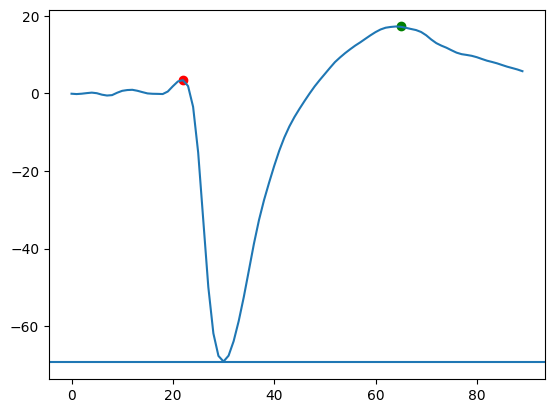

In [223]:
plt.plot(wf)
plt.axhline(peak)
plt.scatter(30 - pre_trough_ind, pre_trough, color='r')
plt.scatter(30 + post_trough_ind, post_trough, color='g')

In [224]:
wf_list = combined_tagged_units_filtered[f'wf{waveform_version}'].values
peak_list = combined_tagged_units_filtered[f'peak{waveform_version}'].values

# Stack waveforms into 2D array (n_units x n_timepoints)
wf_array = np.vstack(wf_list)

# Normalize each row by corresponding peak value
wf_norm = wf_array / peak_list[:, np.newaxis]  # shape: (n_units, n_timepoints)


In [225]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
all_wfs = []
all_peaks = []
curr_session = None

all_wfs = combined_tagged_units_filtered[f'wf{waveform_version}'].tolist()
# all_wfs_aligned = combined_tagged_units_filtered['wf_aligned'].tolist()
all_peaks = combined_tagged_units_filtered[f'peak{waveform_version}'].tolist()

all_wfs = np.array(all_wfs)
# all_wfs_aligned = np.array(all_wfs_aligned)
baseline = np.mean(all_wfs[:, :3], axis=1, keepdims=True) 
peaks = np.array(all_peaks).reshape(-1, 1) 

all_wfs_nl = (all_wfs - baseline) / ((np.squeeze(all_wfs[:, 30]) - np.squeeze(baseline))[:, np.newaxis])
all_wfs_nl_raw = all_wfs/all_wfs[:,30][:, np.newaxis]
all_wfs_nl[all_wfs_nl_raw[:, 0]>1, :] = np.nan  # remove bad waveforms
all_wfs_nl_clean = all_wfs_nl[~np.isnan(all_wfs_nl[:,0])]


## heat map all waveforms, normalized

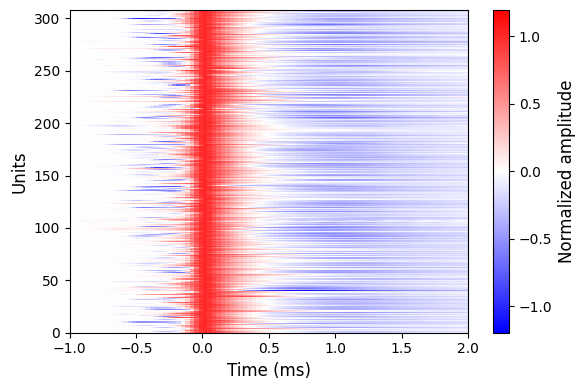

In [226]:
fig, ax = plt.subplots(figsize=(6, 4))
max_abs = np.max(np.abs(all_wfs_nl_clean))
g = ax.imshow(all_wfs_nl_clean, aspect='auto', cmap='bwr', vmin=-max_abs, vmax=max_abs,
               extent=[-30/30, 60/30, 0, all_wfs_nl_clean.shape[0]], interpolation='None')
cbar = plt.colorbar(g, ax=ax)
cbar.set_label('Normalized amplitude', fontsize=12)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Units', fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(target_folder, f'waveform_all_heatmap.pdf'), dpi=300, bbox_inches='tight')


In [227]:
pca = PCA(n_components=8)
pc_time = (np.arange(90) - 30)/30000 * 1000  # assuming 90 samples in the waveform
pca_result = pca.fit_transform(all_wfs_nl_clean)
explained_variance = pca.explained_variance_ratio_
coeff = pca.components_
mean = pca.mean_
all_wfs_pc = pca.inverse_transform(pca_result)

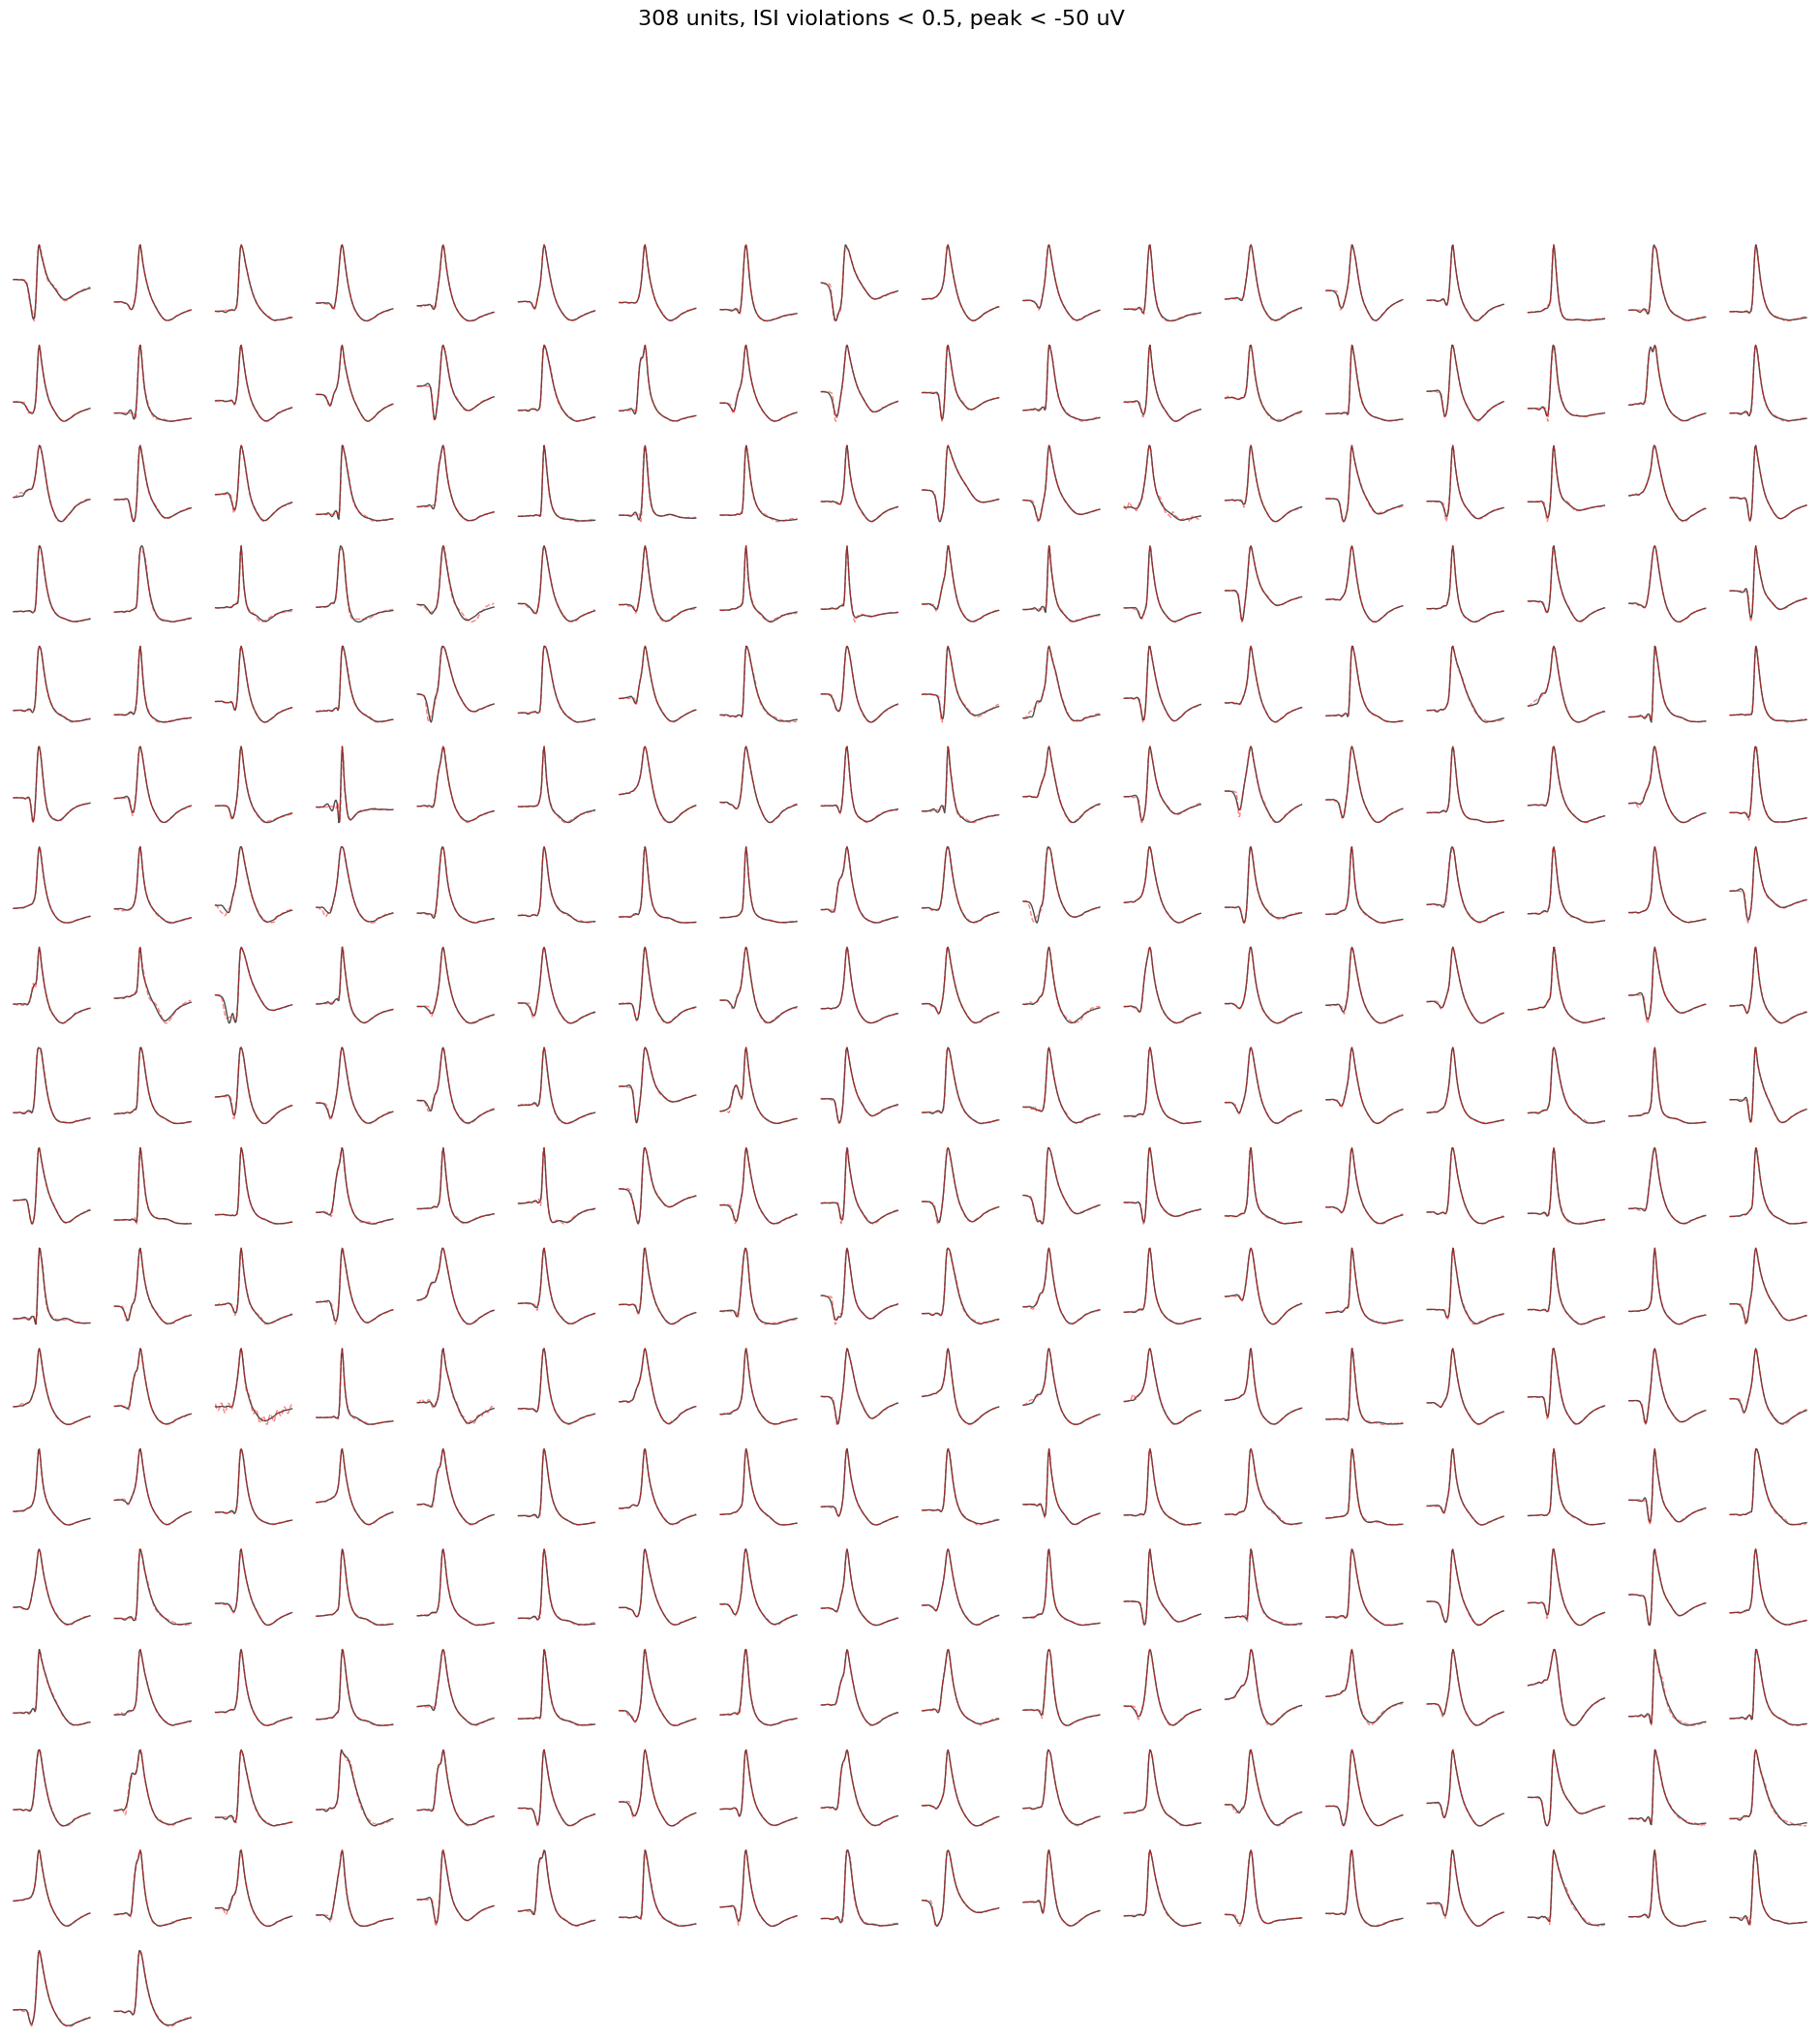

In [228]:
fig = plt.figure(figsize=(24, 24))
gs = gridspec.GridSpec(int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), figure=fig)
for i in range(len(all_wfs_nl_clean)):
    ax = fig.add_subplot(gs[i])
    plt.plot(pc_time, all_wfs_pc[i], alpha=0.7, color='k', linewidth=1);
    plt.plot(pc_time, all_wfs_nl_clean[i], color='r', alpha=0.5, linestyle='--', linewidth=1)
    # turn off the axis
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)    
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.suptitle(title, fontsize=16)
plt.savefig(fname=os.path.join(target_folder, f'All-wf_{criteria_name}.pdf'))


In [229]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Custom single-color colormap: light gray → full red
colors = [(0.4, 0.4, 0.4), (0.6, 0.3, 0.3), (1.0, 0.0, 0.0)]  # RGB for low/high
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

In [230]:
# load spatial info
filter = combined_features['isi_violations'].values < 0.5
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = mesh_vertices_mm[:, ml]

ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left


In [231]:
# perform spatial dependence analysis for all features
spatial_dependence_results = {}
for feature_name in wf_features.columns:
    # if numeric
    if not np.issubdtype(wf_features[feature_name].dtype, np.number):
        continue
    values = combined_features[feature_name].values
    result = spatial_dependence_summary(
        ccfs,
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=2000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result

In [232]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in spatial_dependence_results.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(spatial_dependence_results.keys()):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_permutation_r2'] for feat in spatial_dependence_results.keys()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(spatial_dependence_results.keys()):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_permutation_r2_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
# save results
results_file = os.path.join(target_folder, f'spatial_dependence_results_{criteria_name}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(spatial_dependence_results, f)

/tmp/ipykernel_393995/3025110452.py:55: RuntimeWarning: Mean of empty slice
  mean_wf = np.nanmean(all_wfs_nl[filter][bin_mask], axis=0)
/opt/conda/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


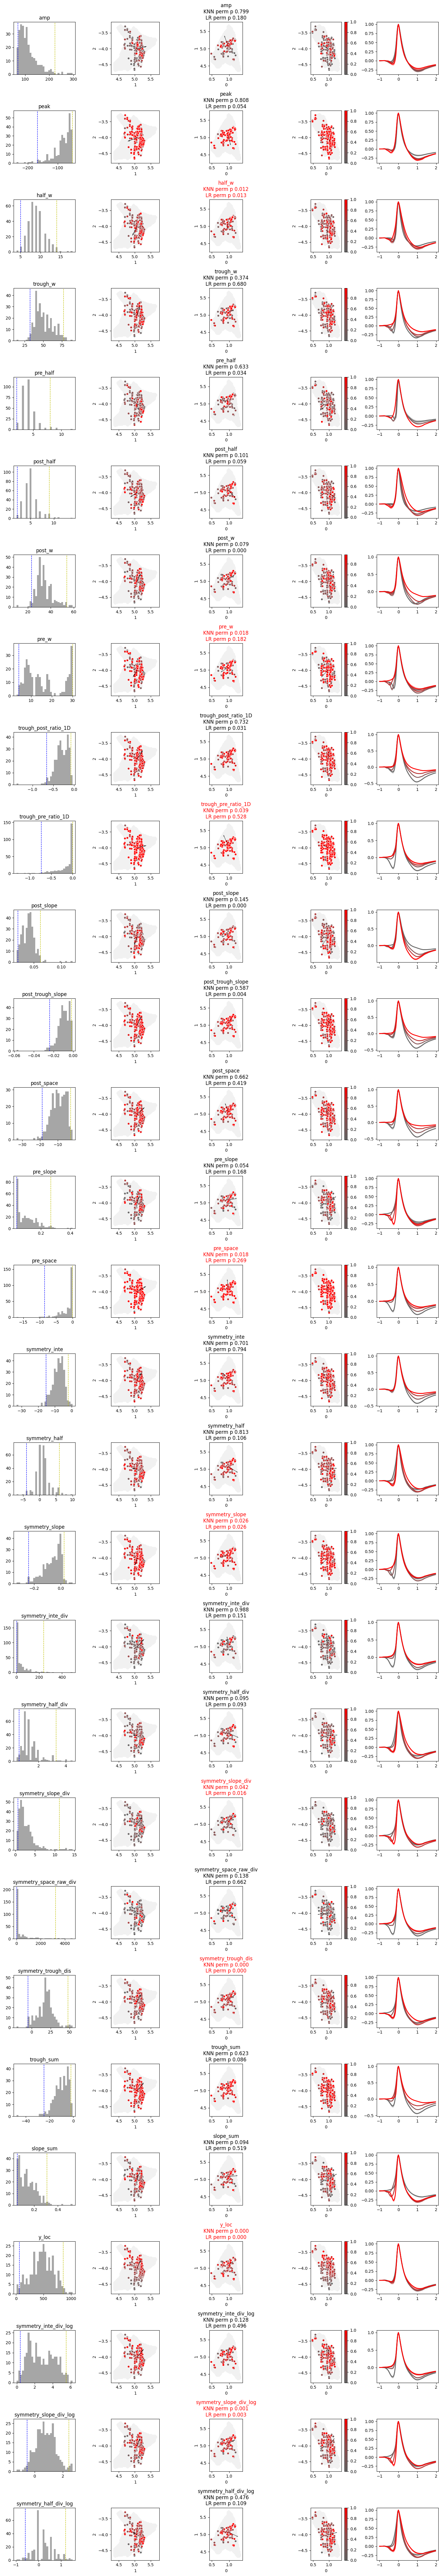

In [233]:
from matplotlib.colors import Normalize
from scipy.stats import rankdata
norm = Normalize(vmin=0, vmax=1)
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = mesh_vertices_mm[:, ml]

# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
filter = combined_features['isi_violations'].values < 0.5
# CCF coordinates and planes
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bin_num = 4
# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

plot_features = spatial_dependence_results.keys()
fig, axes = plt.subplots(len(plot_features), 5, figsize=(15, 3*len(plot_features)))

for ind, feature in enumerate(plot_features):
    ax = axes[ind, 0]
    color_code = wf_features[feature].values
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    top_90 = np.quantile(color_code, 0.98)
    bottom_10 = np.quantile(color_code, 0.02)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    # sort_ind = np.random.permutation(sort_ind)  # randomize the order within same color
    bin_edges = np.quantile(color_code, np.linspace(0, 1, bin_num + 1))
    ax = axes[ind, -1]
    for b in range(bin_num):
        bin_mask = (color_code >= bin_edges[b]) & (color_code < bin_edges[b + 1])
        mean_wf = np.nanmean(all_wfs_nl[filter][bin_mask], axis=0)
        mean_sem = np.nanstd(all_wfs_nl[filter][bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
        ax.plot(pc_time, mean_wf, label=f'Bin {b + 1} ({bin_edges[b]:.2f}-{bin_edges[b + 1]:.2f})', 
                color=cmap(b / (bin_num - 1)), linewidth=2)
        ax.fill_between(pc_time, mean_wf - mean_sem, mean_wf + mean_sem, color=cmap(b / (bin_num - 1)), 
                        alpha=0.3)
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        sc = ax.scatter(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], c=color_code_nl[sort_ind], cmap=cmap, s=25, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']<0.05:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"KNN perm p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']:.3f}\n"
                f"LR perm p {spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_feature_in_space_{criteria_name}.png'), dpi=300, bbox_inches='tight')

In [234]:
# focus_features_ori = ['half_w', 'pre_half', 'post_w', 
#                 'trough_post_ratio_1D', 'post_slope', 'post_space', 'pre_space', 'trough_pre_ratio_1D',
#                 'symmetry_slope', 'symmetry_slope_div_log', 'symmetry_inte_div', 'symmetry_inte_div_log',
#                 ]
# focus_features_ori = ['half_w', 'pre_half', 'post_w', 
#                 'trough_post_ratio_1D', 'post_slope', 'trough_pre_ratio_1D', 'pre_slope',
#                 'symmetry_inte_div_log', 'symmetry_trough_dis'
#                 ]
# focus_features = focus_features_ori

In [289]:
focus_features_correct = ['half_w', 
                # 'pre_half', 
                'post_w', 
                'trough_post_ratio_1D', 
                # 'post_trough_slope', 
                'trough_pre_ratio_1D', 
                'pre_slope',
                'symmetry_slope_div_log',
                'symmetry_trough_dis', 
                'symmetry_inte_div_log', 
                'slope_sum'
                ]
focus_features = focus_features_correct

/tmp/ipykernel_393995/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_393995/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_393995/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')


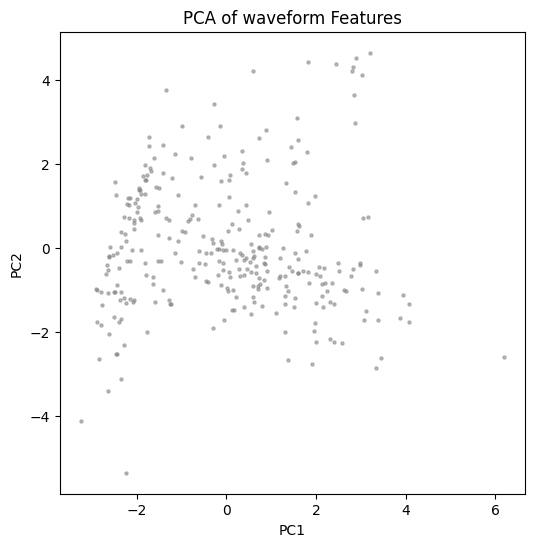

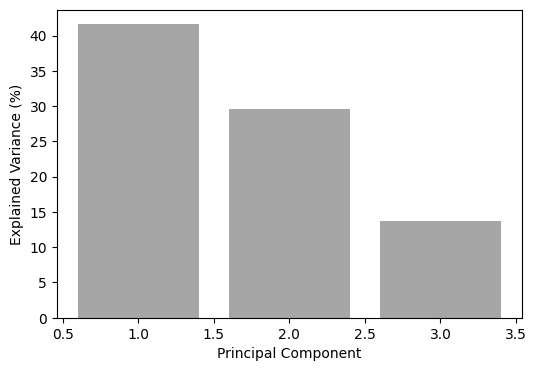

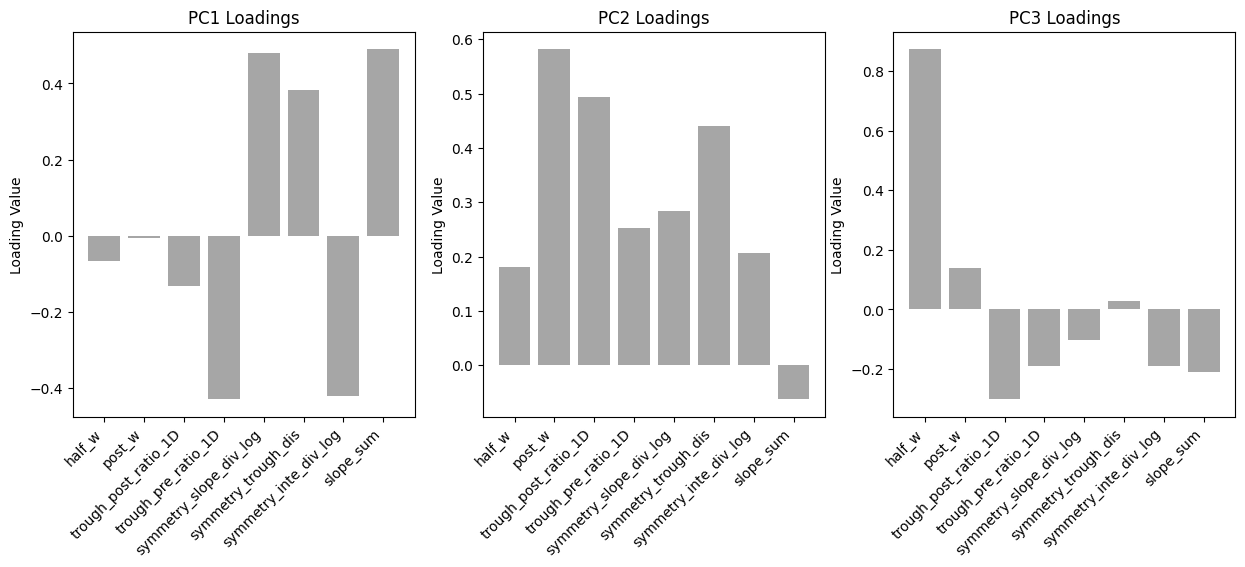

In [290]:
from sklearn.decomposition import PCA
feature_mat = combined_features[focus_features].values[filter]
# remove rows with nan
nan_ind = np.isnan(feature_mat).any(axis=1)
feature_mat = feature_mat[~nan_ind]
# zscore
from scipy.stats import zscore
feature_mat = zscore(feature_mat, axis=0, nan_policy='omit')

pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_mat)
# plot
fig = plt.figure(figsize=(6, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='gray', alpha=0.5, s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of waveform Features')
# plot explained variance ratio
explained_var = pca.explained_variance_ratio_
fig = plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_var)+1), explained_var*100, color='gray', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')

# plot how each features contribute to each PC, plot by PC
components = pca.components_
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.bar(focus_features, components[i], color='gray', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features, rotation=45, ha='right')

In [291]:
# append pc to wf_df
pc_filtered = np.full((np.sum(filter), 3), np.nan)
pc_filtered[~nan_ind] = pca_result
combined_features['wf_pc_1'] = np.nan
combined_features['wf_pc_2'] = np.nan
combined_features['wf_pc_3'] = np.nan
combined_features.loc[filter, 'wf_pc_1'] = pc_filtered[:, 0]
combined_features.loc[filter, 'wf_pc_2'] = pc_filtered[:, 1]
combined_features.loc[filter, 'wf_pc_3'] = pc_filtered[:, 2]

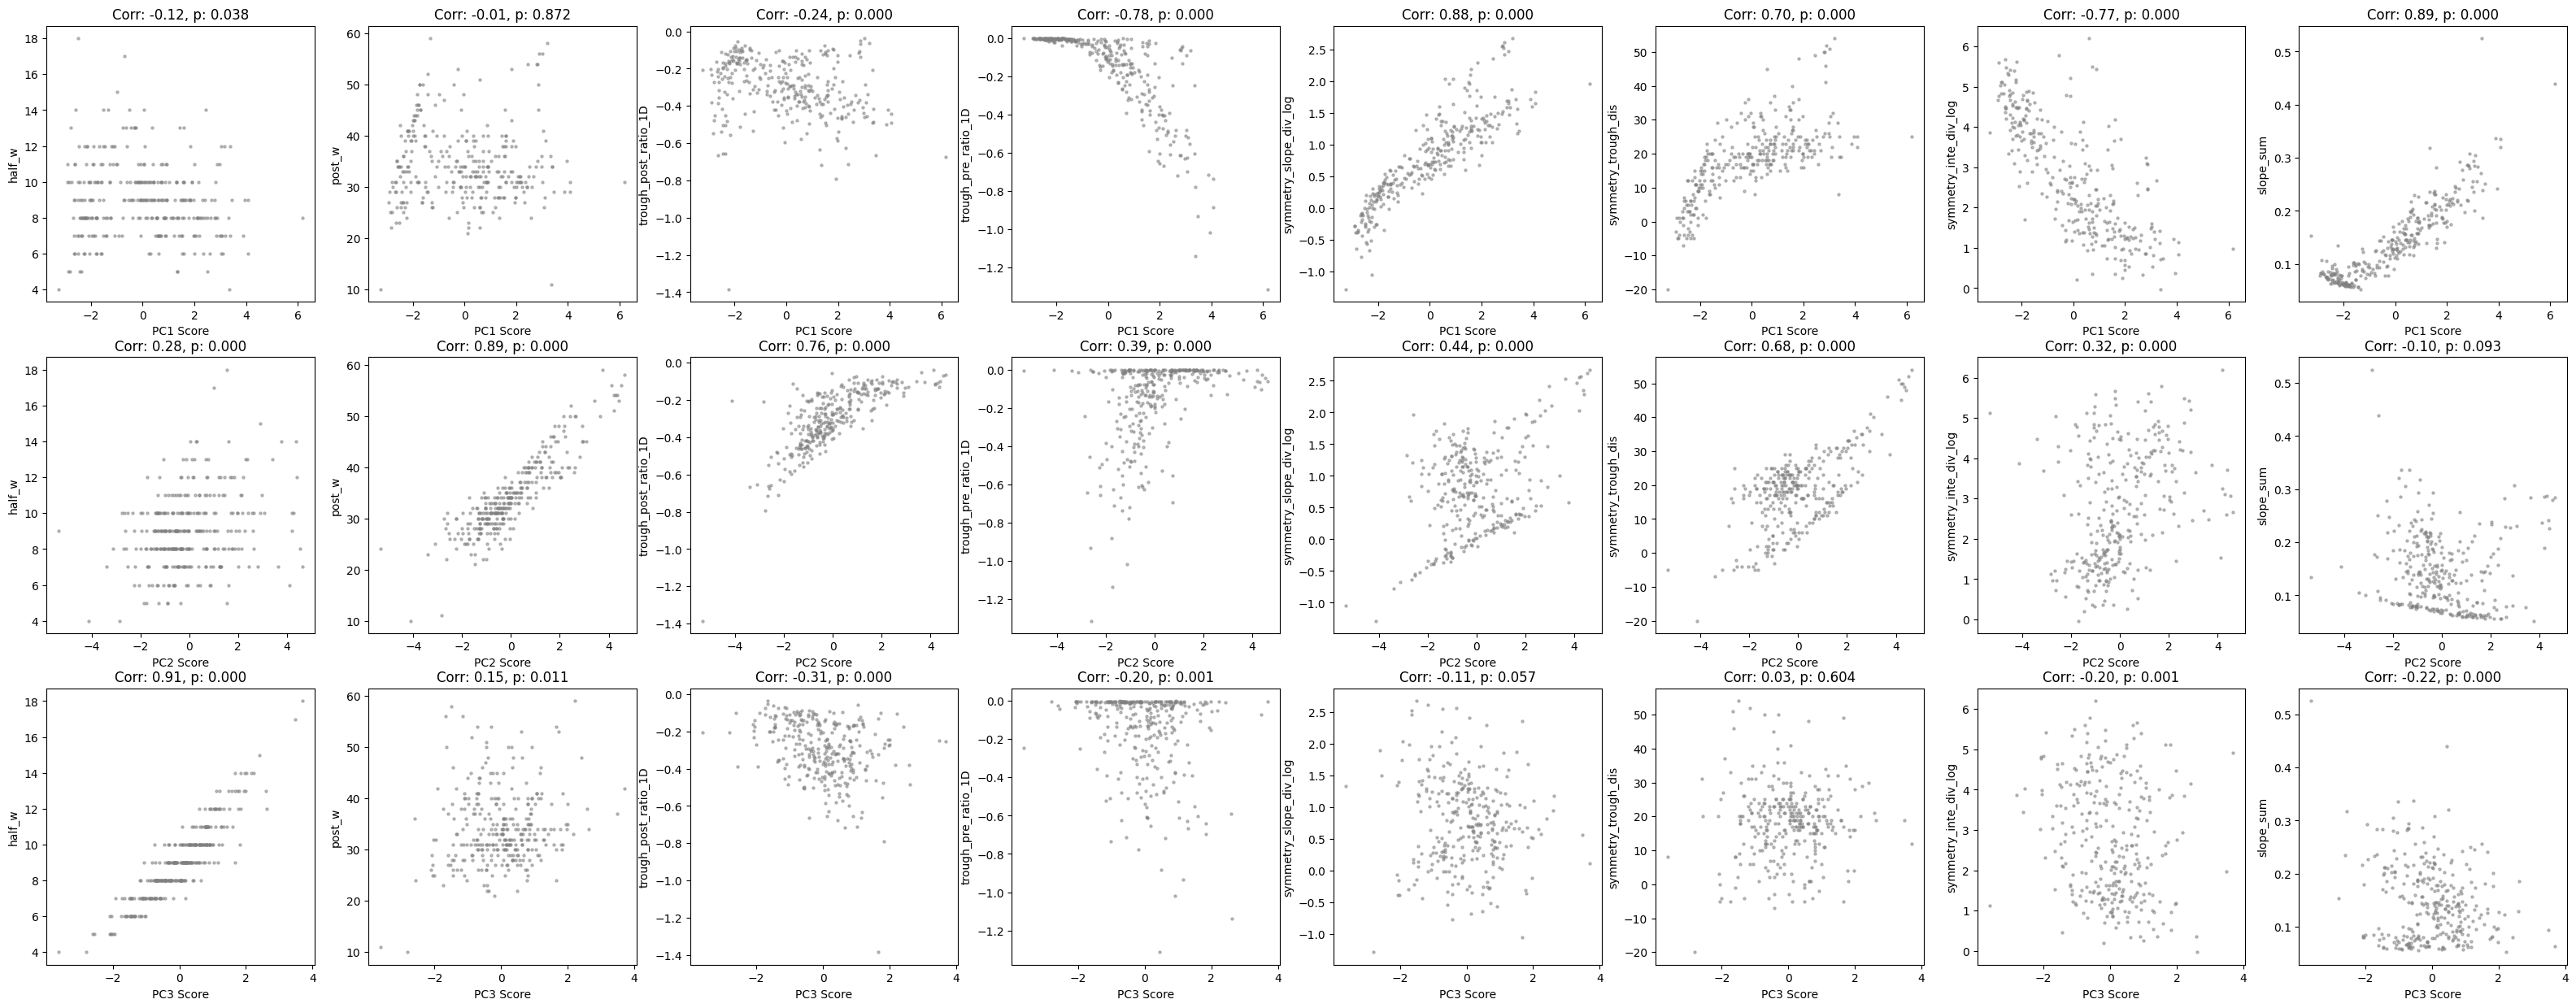

In [292]:
# scatter plot of each features for PC1 - PC3, each row is one pc, each columns if one feature, compute correlation and p value
fig, axes = plt.subplots(3, len(focus_features), figsize=(5*len(focus_features), 15))
for i in range(3):
    for j, feature in enumerate(focus_features):
        ax = axes[i, j]
        feature_values = combined_features[feature].values[filter]
        feature_values = feature_values[~nan_ind]
        ax.scatter(pca_result[:, i], feature_values, c='gray', alpha=0.5, s=5)
        ax.set_xlabel(f'PC{i+1} Score')
        ax.set_ylabel(feature)
        # compute correlation
        from scipy.stats import pearsonr
        corr, pval = pearsonr(pca_result[:, i], feature_values)
        ax.set_title(f'Corr: {corr:.2f}, p: {pval:.3f}')

In [239]:
pre_slope

[np.float64(0.3855945975154463),
 np.float64(0.10381619797352017),
 np.float64(0.0372230865460597),
 np.float64(0.11189590135786698),
 np.float64(0.10468434946942488),
 np.float64(0.09506710603342096),
 np.float64(0.05284222004652023),
 np.float64(0.1521550038320583),
 np.float64(0.14253013426278097),
 np.float64(0.03461783617953112),
 np.float64(0.09812146415061841),
 np.float64(0.15400766385191406),
 np.float64(0.10251639772775498),
 np.float64(0.11198501743635723),
 np.float64(0.15429880239059995),
 np.float64(0.03342965534729066),
 np.float64(0.1501169598876558),
 np.float64(0.04800100829146238),
 np.float64(0.10034528791806963),
 np.float64(0.18144383234759942),
 np.float64(0.1354541155661827),
 np.float64(0.0845669616581307),
 np.float64(0.19327289417822507),
 np.float64(0.03575227704140994),
 np.float64(0.0941650796685098),
 np.float64(0.07941862148758773),
 np.float64(0.1283213099169749),
 np.float64(0.23206567488990998),
 np.float64(0.03849932476695782),
 np.float64(0.15858007

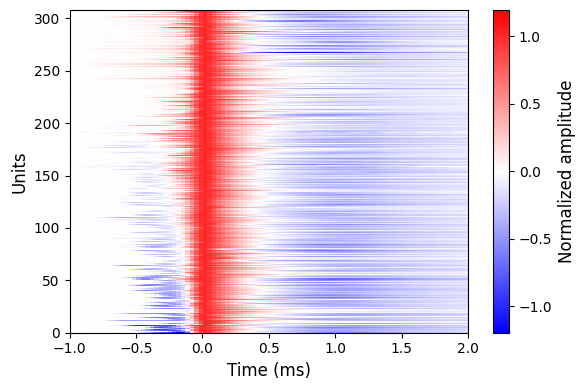

In [293]:
fig, ax = plt.subplots(figsize=(6, 4))
max_abs = np.max(np.abs(all_wfs_nl_clean))
sort_ind = np.argsort(pca_result[:, 0])
g = ax.imshow(all_wfs_nl_clean[~nan_ind, :][sort_ind], aspect='auto', cmap='bwr', vmin=-max_abs, vmax=max_abs,
               extent=[-30/30, 60/30, 0, all_wfs_nl_clean.shape[0]], interpolation='None')
cbar = plt.colorbar(g, ax=ax)
cbar.set_label('Normalized amplitude', fontsize=12)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Units', fontsize=12)
fig.tight_layout()
plt.savefig(os.path.join(target_folder, f'waveform_all_heatmap_pc1_sorted.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'waveform_all_heatmap_pc1_sorted.svg'), dpi=300, bbox_inches='tight')


In [294]:
wf_features.columns

Index(['unit', 'session', 'amp', 'peak', 'half_w', 'trough_w', 'pre_half',
       'post_half', 'post_w', 'pre_w', 'trough_post_ratio_1D',
       'trough_pre_ratio_1D', 'post_slope', 'post_trough_slope', 'post_space',
       'pre_slope', 'pre_space', 'symmetry_inte', 'symmetry_half',
       'symmetry_slope', 'symmetry_inte_div', 'symmetry_half_div',
       'symmetry_slope_div', 'symmetry_space_raw_div', 'symmetry_trough_dis',
       'trough_sum', 'slope_sum', 'y_loc', 'probe', 'symmetry_inte_div_log',
       'symmetry_slope_div_log', 'symmetry_half_div_log'],
      dtype='object')

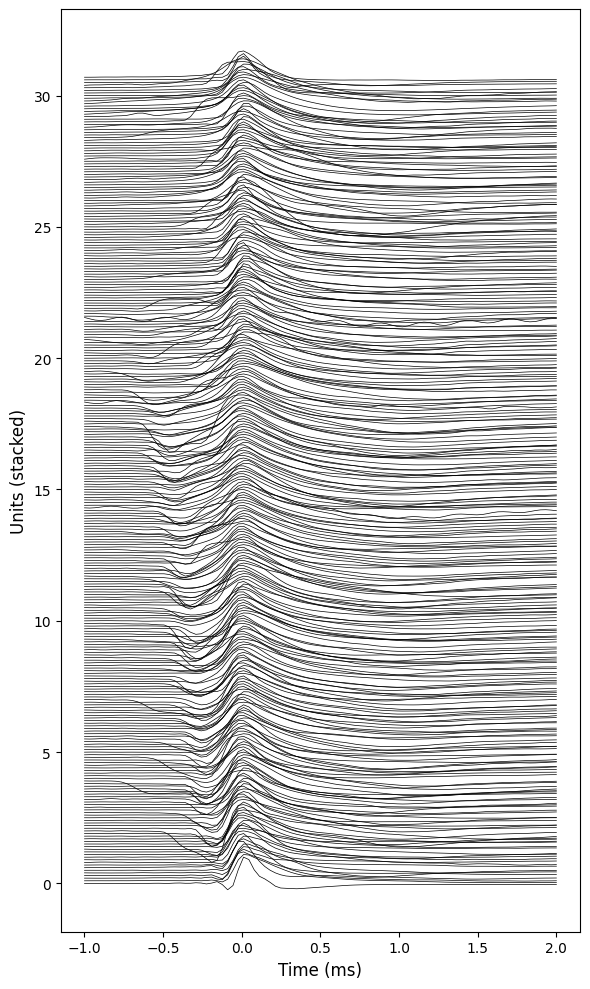

In [295]:
fig, ax = plt.subplots(figsize=(6, 10))
sort_ind = np.argsort(wf_features['pre_w'].values[filter][~nan_ind])
# sort_ind = np.argsort(pca_result[:, 0])
sorted_wfs = all_wfs_nl_clean[~nan_ind, :][sort_ind]

time_axis = np.linspace(-30/30, 60/30, sorted_wfs.shape[1])

offset =0.1   # vertical spacing between traces (tune)

for i, wf in enumerate(sorted_wfs):
    ax.plot(time_axis, wf + i * offset, color='k', linewidth=0.5)

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Units (stacked)', fontsize=12)

fig.tight_layout()
plt.savefig(os.path.join(target_folder, f'waveform_all_lines_sorted.svg'),
            dpi=300, bbox_inches='tight')


In [296]:
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
import os

custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (1, 0, 0)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (0, 1, 1))])

# -------------------------------------------------------------------------
# helper: project mesh to plane and return 2D contours
# ------------------------------------------------------------------------

# -------------------------------------------------------------------------
# main plotting code
# -------------------------------------------------------------------------



# coordinates setup
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])

# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}


## waveform pc in space

In [297]:
# test significant correlation with spatial location
spatial_dependence_results_pca = {}
for pc_ind in range(2):
    values = combined_features[f'wf_pc_{pc_ind+1}'].values
    result = spatial_dependence_summary(
        ccfs,
        values[filter],
        k_neighbors=30,
        n_splits=5,
        permutations=5000,
        seed=42,
    )
    spatial_dependence_results_pca[f'wf_pc_{pc_ind+1}'] = result

In [298]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['p_value_permutation'] for i in range(2)]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i in range(2):
    feature_name = f'wf_pc_{i+1}'
    spatial_dependence_results_pca[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results_pca[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['p_value_permutation_r2'] for i in range(2)]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i in range(2):
    feature_name = f'wf_pc_{i+1}'
    spatial_dependence_results_pca[feature_name]['linear_trend']['p_value_permutation_r2_fdr'] = pvals_corrected[i]
    spatial_dependence_results_pca[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
# save results
results_file = os.path.join(target_folder, f'spatial_dependence_results_pca_{criteria_name}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(spatial_dependence_results_pca, f)


In [364]:
from cmcrameri import cm
custom_cmap = cm.batlowK_r
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (0, 1, 1)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (1, 0, 0))])

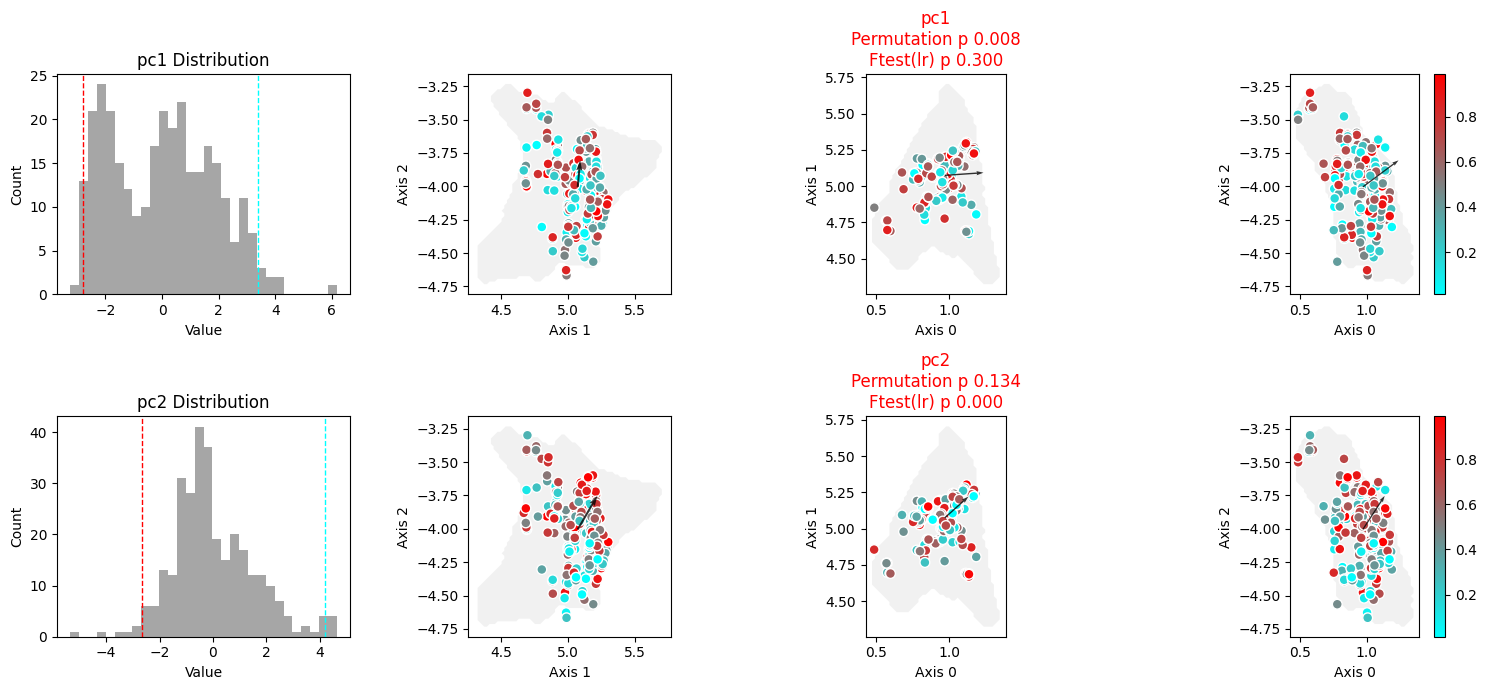

In [300]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
version = 'pc'
for i in range(2):
    # normalize PC values
    pc_values = combined_features[f'wf_{version}_{i+1}'].values[filter]
    low, high = np.nanquantile(pc_values, [0.02, 0.98])
    pc_values_nl = np.clip(pc_values, low, high)
    pc_values_nl = (pc_values_nl - low) / (high - low)
    pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
    sort_ind = np.argsort(pc_values_nl)
    # shuffle 
    sort_ind = np.random.permutation(len(sort_ind))

    # ---------------- histogram ----------------
    ax = axes[i, 0]
    ax.hist(pc_values, bins=30, color='gray', alpha=0.7)
    ax.axvline(low, color='r', linestyle='--', linewidth=1)
    ax.axvline(high, color='cyan', linestyle='--', linewidth=1)
    ax.set_title(f'{version}{i+1} Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

    # ---------------- projections ----------------
    for j, (plane_name, plane_axes) in enumerate(planes.items()):
        ax = axes[i, j + 1]

        # fill mesh projection contours
        for c in mesh_contours[plane_name]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # project your CCF data to the same plane
        proj_ccf = ccfs[:, plane_axes]
        jitter_on_x = np.random.normal(0, 0.02, size=ccfs.shape[0])
        jitter_on_y = np.random.normal(0, 0.02, size=ccfs.shape[0])
        sc = ax.scatter(
            proj_ccf[sort_ind, 0], proj_ccf[sort_ind, 1],
            c=pc_values_nl[sort_ind], cmap=custom_cmap,
            s=50, edgecolor=[1, 1, 1], alpha=1
        )
        # plot arrow
        coef = spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[plane_axes[0]],
            arrow_start[plane_axes[1]],
            arrow_vec[plane_axes[0]],
            arrow_vec[plane_axes[1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )


        ax.set_aspect('equal')
        ax.set_xlabel(f'Axis {plane_axes[0]}')
        ax.set_ylabel(f'Axis {plane_axes[1]}')

        if plane_name == 'hor':
            if (spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['p_value_permutation'] < 0.05) or (spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['p_value_permutation_r2'] < 0.05):
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{version}{i+1}\n"
                f"Permutation p {spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['p_value_permutation']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['p_value_permutation_r2']:.3f}",
                color=title_color
            )
        if plane_name == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_{version}_in_space_{criteria_name}_contour.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_{version}_in_space_{criteria_name}_contour.svg'),
            dpi=300, bbox_inches='tight')
plt.show()


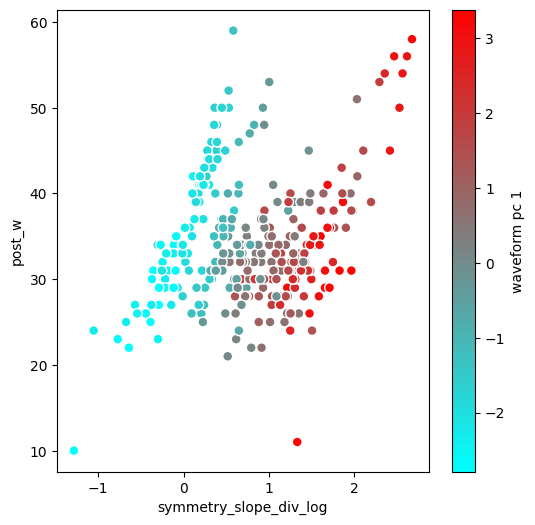

In [301]:
fig = plt.figure(figsize=(6, 6))
x_val = 'symmetry_slope_div_log'
y_val = 'post_w'

x = combined_features[x_val][filter]
# add a bit noise
# x = x + np.random.normal(0, 0.01, size=x.shape)
y = combined_features[y_val][filter]
color_code = combined_features['wf_pc_1'][filter]

sc = plt.scatter(x, y, c = color_code, cmap = custom_cmap, alpha = 1, edgecolor = [1, 1, 1], s = 50, norm=Normalize(vmin=np.quantile(color_code, 0.02), vmax=np.quantile(color_code, 0.98)))
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.colorbar(sc, label='waveform pc 1')
plt.savefig(os.path.join(target_folder, f'{x_val}_vs_{y_val}_{criteria_name}_color_pc1.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'{x_val}_vs_{y_val}_{criteria_name}_color_pc1.svg'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(wf_folder, f'cca_behavioral_comp1_vs_postw_symmslope.svg'), dpi=300, bbox_inches='tight')

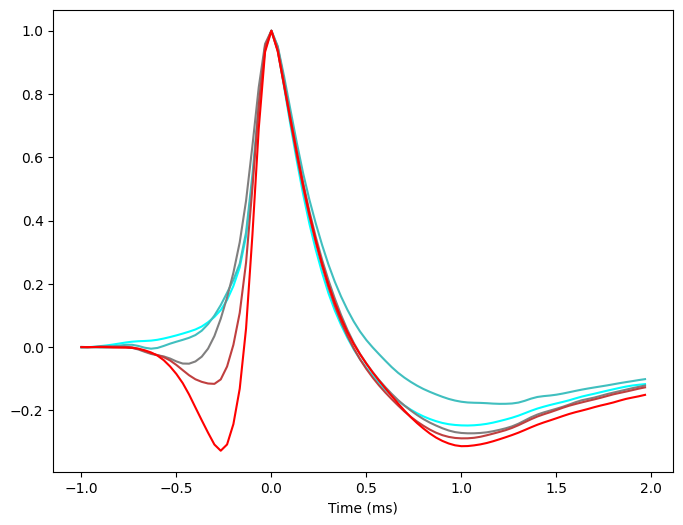

In [353]:
# plot mean waveforms, binned by pc1
num_bins = 5
fig = plt.figure(figsize=(8, 6))
pc_int = 1
bin_edges = np.quantile(combined_features[f'wf_pc_{pc_int}'][filter], np.linspace(0, 1, num_bins + 1))
for i in range(num_bins):
    bin_mask = (combined_features[f'wf_pc_{pc_int}'][filter] >= bin_edges[i]) & (combined_features[f'wf_pc_{pc_int}'][filter] < bin_edges[i + 1])
    mean_wf = np.nanmean(all_wfs_nl_clean[bin_mask], axis=0)
    plt.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(i / (num_bins - 1)))
plt.xlabel('Time (ms)')

fig.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_pc_{pc_int}_{criteria_name}.pdf'))
plt.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_pc_{pc_int}_{criteria_name}.svg'))

## example waveforms in space

In [325]:
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left


Example units selected: [np.int64(94), np.int64(199), np.int64(152)]


/tmp/ipykernel_393995/1200306303.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


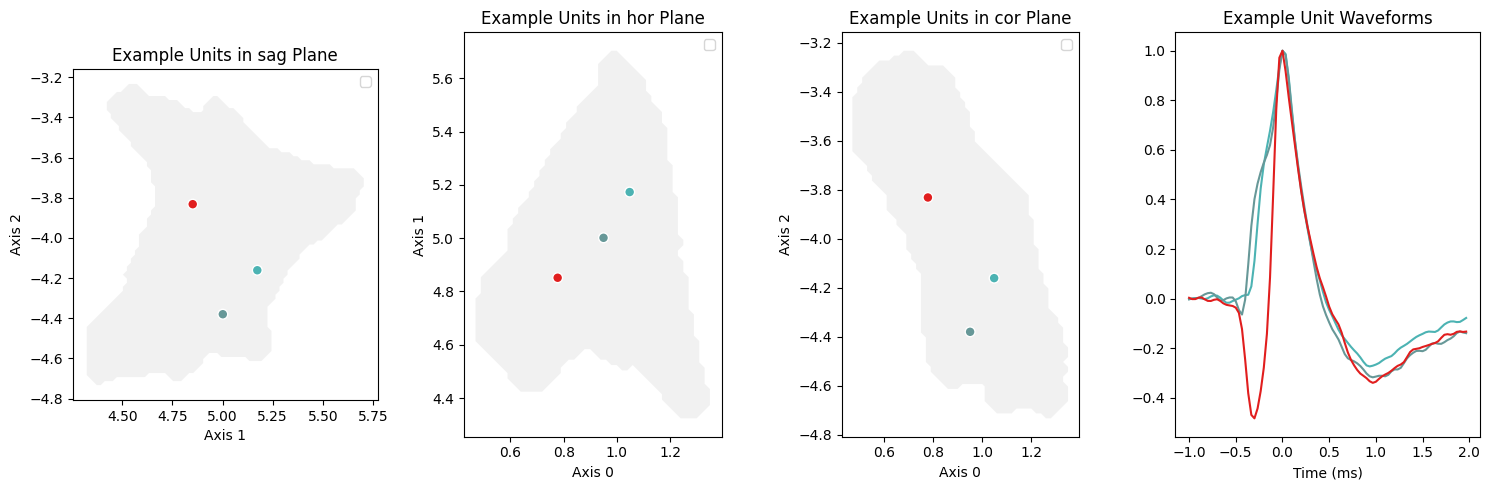

In [335]:
# pick example units from each bin and scatter in space
example_units = []
ccf_valid = np.all(~np.isnan(ccfs), axis=1)
num_bins = 3
bin_edges = np.quantile(combined_features['wf_pc_1'][filter], np.linspace(0, 1, num_bins + 1))
for i in range(num_bins):
    bin_mask = (combined_features['wf_pc_1'][filter] >= bin_edges[i]) & (combined_features['wf_pc_1'][filter] < bin_edges[i + 1])
    bin_indices = np.where(bin_mask & ccf_valid)[0]
    if len(bin_indices) > 0:
        # randomly select one unit from the bin
        example_units.append(np.random.choice(bin_indices))
# example_units = np.array([201, np.int64(91), np.int64(100)])
print('Example units selected:', example_units)
pc_values = combined_features['wf_pc_1'].values[filter]
low, high = np.nanquantile(pc_values, [0.02, 0.98])
pc_values_nl = np.clip(pc_values, low, high)
pc_values_nl = (pc_values_nl - low) / (high - low)
pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for plane_ind, (plane_name, plane_axes) in enumerate(planes.items()):
    ax = axes[plane_ind]
    # fill mesh projection contours
    for c in mesh_contours[plane_name]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    proj_ccf = ccfs[:, plane_axes]
    sc = ax.scatter(
        proj_ccf[example_units, 0], proj_ccf[example_units, 1],
        c=pc_values_nl[example_units], cmap=custom_cmap, vmin=0, vmax=1,
        s=50, edgecolor=[1, 1, 1], alpha=1
    )
    
    ax.set_aspect('equal')
    ax.set_xlabel(f'Axis {plane_axes[0]}')
    ax.set_ylabel(f'Axis {plane_axes[1]}')
    ax.set_title(f'Example Units in {plane_name} Plane')
    ax.legend()

# plot waveform on the last axis
ax = axes[3]
for i, unit_idx in enumerate(example_units):
    mean_wf = all_wfs_nl_clean[unit_idx]
    ax.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(pc_values_nl[unit_idx]))
ax.set_xlabel('Time (ms)')
ax.set_title('Example Unit Waveforms')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_pc1_binned_waveforms_and_examples_{criteria_name}.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_pc1_binned_waveforms_and_examples_{criteria_name}.svg'),
            dpi=300, bbox_inches='tight')

## CCA

In [354]:
focus_features_cca = ['half_w', 
                # 'pre_half', 
                'post_w', 
                'trough_post_ratio_1D', 
                # 'post_trough_slope', 
                'trough_pre_ratio_1D', 
                'pre_slope',
                'symmetry_slope_div_log',
                'symmetry_trough_dis', 
                'symmetry_inte_div_log', 
                'slope_sum'
                ]
focus_features = focus_features_cca

CCA CCF Component 1 Coefficients:
  x_ccf: 0.2283
  y_ccf: 0.3162
  z_ccf: 0.9208
CCA CCF Component 2 Coefficients:
  x_ccf: -0.8123
  y_ccf: 0.5832
  z_ccf: 0.0011
CCA CCF Component 3 Coefficients:
  x_ccf: -0.5367
  y_ccf: -0.7483
  z_ccf: 0.3900


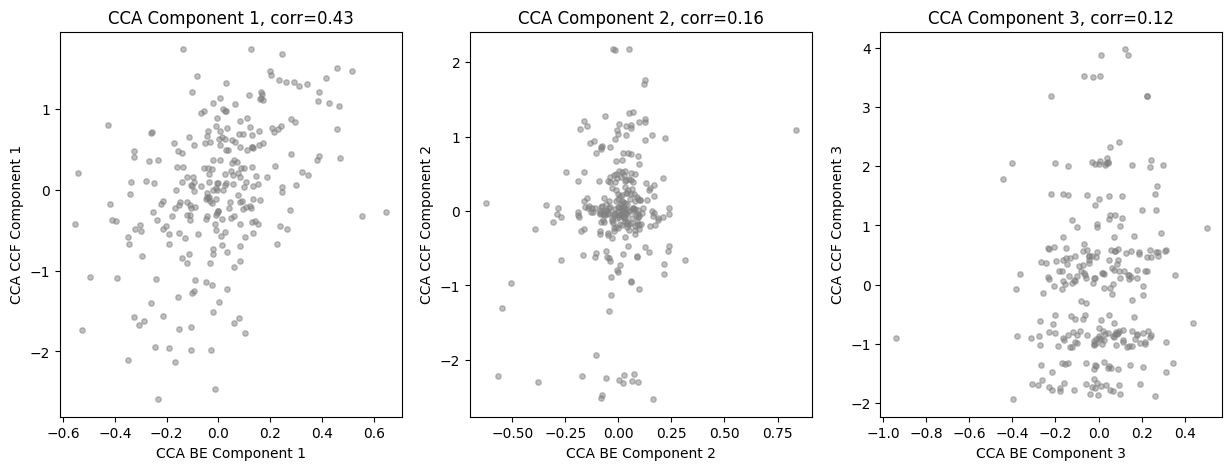

In [303]:
# cca in space
from sklearn.cross_decomposition import CCA
filters = combined_features['isi_violations'] < 0.5
focus_features_cca = focus_features
cca_wf_mat = combined_features[focus_features].values[filter]
ccf_mat = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
# remove nan
nan_ind_cca = np.isnan(cca_wf_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_wf_mat = cca_wf_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]
# zscore
cca_wf_mat = zscore(cca_wf_mat, axis=0, nan_policy='omit')
# ccf_mat = zscore(ccf_mat, axis=0, nan_policy='omit')
cca = CCA(n_components=3)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_wf_mat, ccf_mat)
# plot cca result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.scatter(cca_result_be[:, i], cca_result_ccf[:, i], c='gray', alpha=0.5, s=15)
    ax.set_xlabel(f'CCA BE Component {i+1}')
    ax.set_ylabel(f'CCA CCF Component {i+1}')
    ax.set_title(f'CCA Component {i+1}, corr={np.corrcoef(cca_result_be[:, i], cca_result_ccf[:, i])[0, 1]:.2f}')
# # print coefficients
# cca_be_coeff = cca.x_weights_
# for i in range(3):
#     print(f'CCA BE Component {i+1} Coefficients:')
#     for j, feature in enumerate(focus_features):
#         print(f'  {feature}: {cca_be_coeff[j, i]:.4f}')
# print cca ccf coeff
cca_ccf_coeff = cca.y_weights_
for i in range(3):
    print(f'CCA CCF Component {i+1} Coefficients:')
    for j, axis in enumerate(['x_ccf', 'y_ccf', 'z_ccf']):
        print(f'  {axis}: {cca_ccf_coeff[j, i]:.4f}')


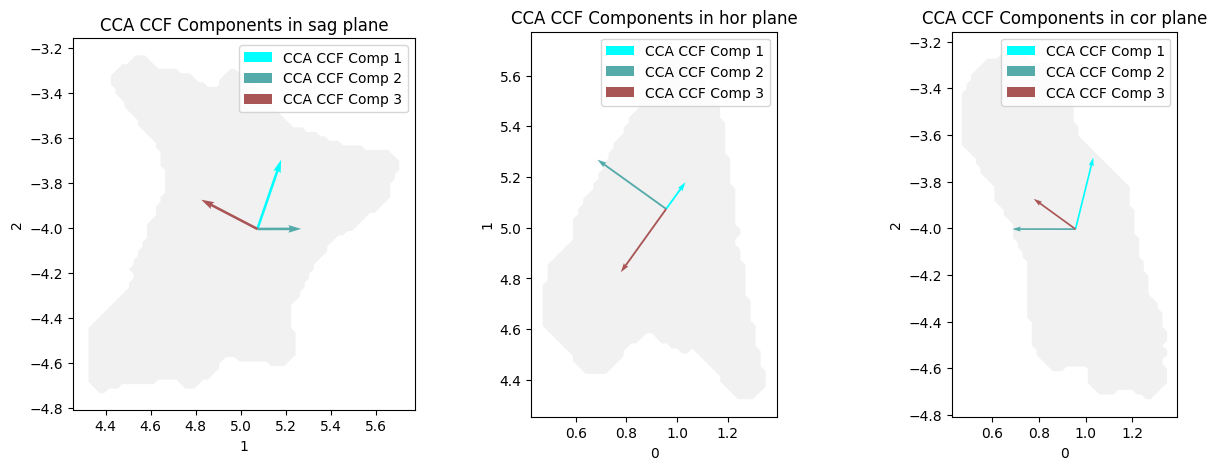

In [304]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    for c in mesh_contours[plane]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    for i in range(3):
        vec = cca_ccf_coeff[:, i]
        # normalize vector for better visualization
        vec = vec / np.linalg.norm(vec)
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=custom_cmap(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend(loc='upper right')

In [305]:
cca_vecs, cca_ccf_coeff

(array([[ 0.2282554 , -0.8123048 ],
        [ 0.31616739,  0.58323211],
        [ 0.9208353 ,  0.00110115]]),
 array([[ 0.2282554 , -0.8123048 , -0.53671257],
        [ 0.31616739,  0.58323211, -0.74825028],
        [ 0.9208353 ,  0.00110115,  0.38995017]]))

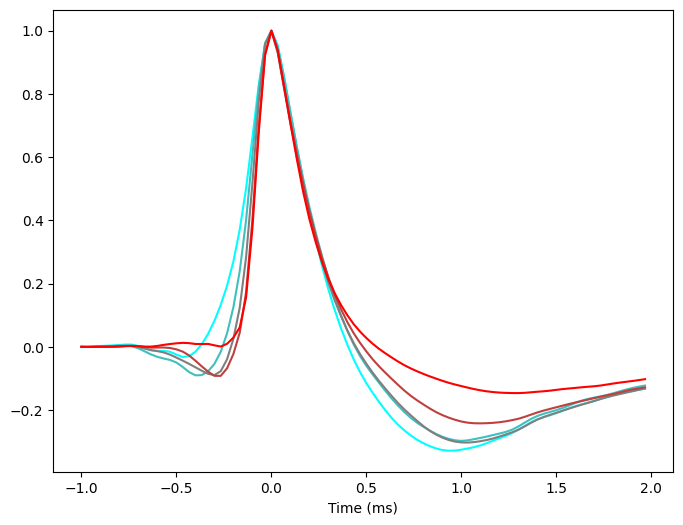

In [306]:
# bin waveforms by cca component 1
cca_comp_1 = cca_result_be[:, 0]
num_bins = 5
fig = plt.figure(figsize=(8, 6))
bin_edges = np.quantile(cca_comp_1, np.linspace(0, 1, num_bins + 1))
for i in range(num_bins):
    bin_mask = (cca_comp_1 >= bin_edges[i]) & (cca_comp_1 < bin_edges[i + 1])
    mean_wf = np.nanmean(all_wfs_nl_clean[~nan_ind_cca][bin_mask], axis=0)
    plt.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(i / (num_bins - 1)))
plt.xlabel('Time (ms)')
fig.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_cca_comp1_{criteria_name}.pdf'))
plt.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_cca_comp1_{criteria_name}.svg'))

Example units selected: [69 58 65]


/tmp/ipykernel_393995/4136096003.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


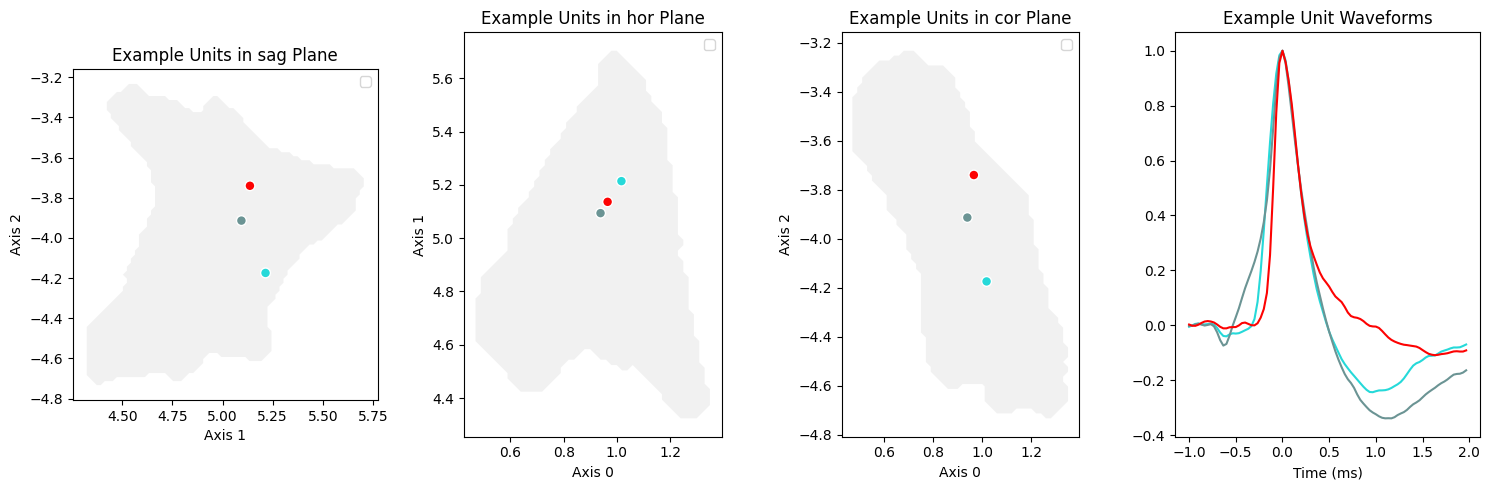

In [352]:
# pick example units from each cca_1 bin and scatter in space
example_units = []
ccf_valid = np.all(~np.isnan(ccfs), axis=1)
num_bins = 3
bin_edges = np.quantile(cca_comp_1, np.linspace(0, 1, num_bins + 1))
all_wfs_nl_clean_cca = all_wfs_nl_clean[~nan_ind_cca]
for i in range(num_bins):
    bin_mask = (cca_comp_1 >= bin_edges[i]) & (cca_comp_1 < bin_edges[i + 1])
    bin_indices = np.where(bin_mask)[0]
    if len(bin_indices) > 0:
        # randomly select one unit from the bin
        example_units.append(np.random.choice(bin_indices))
example_units = np.array([np.int64(69), np.int64(58), np.int64(65)])
print('Example units selected:', example_units)
cca_values = cca_comp_1
low, high = np.nanquantile(cca_values, [0.02, 0.98])
pc_values_nl = np.clip(cca_values, low, high)
pc_values_nl = (pc_values_nl - low) / (high - low)
pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for plane_ind, (plane_name, plane_axes) in enumerate(planes.items()):
    ax = axes[plane_ind]
    # fill mesh projection contours
    for c in mesh_contours[plane_name]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    proj_ccf = ccfs[~nan_ind_cca][:, plane_axes]
    sc = ax.scatter(
        proj_ccf[example_units, 0], proj_ccf[example_units, 1],
        c=pc_values_nl[example_units], cmap=custom_cmap, vmin=0, vmax=1,
        s=50, edgecolor=[1, 1, 1], alpha=1
    )
    
    ax.set_aspect('equal')
    ax.set_xlabel(f'Axis {plane_axes[0]}')
    ax.set_ylabel(f'Axis {plane_axes[1]}')
    ax.set_title(f'Example Units in {plane_name} Plane')
    ax.legend()

# plot waveform on the last axis
ax = axes[3]
for i, unit_idx in enumerate(example_units):
    mean_wf = all_wfs_nl_clean_cca[unit_idx]
    ax.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(pc_values_nl[unit_idx]))
ax.set_xlabel('Time (ms)')
ax.set_title('Example Unit Waveforms')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_cca1_binned_waveforms_and_examples_{criteria_name}.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_cca1_binned_waveforms_and_examples_{criteria_name}.svg'),
            dpi=300, bbox_inches='tight')

# Bootstrapping

In [307]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cross_decomposition import CCA
from collections import defaultdict
alpha = 0.05
ranked = False
# ==========================================================
#   0. ORIGINAL CCA FIT
# ==========================================================
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = combined_features['isi_violations'].values < 0.5
cca_be_mat = combined_features[focus_features].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
# score
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')

if ranked:
    ccf_mat = ccf_mat_ranked

cca = CCA(n_components=2)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

xw = cca.x_weights_.copy()
yw = cca.y_weights_.copy()

n_samples = cca_be_mat.shape[0]
n_features_be = cca_be_mat.shape[1]

# normalized anatomical CCA vectors
cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)


# ==========================================================
#   1. BIN DATA INTO 3D VOXELS
# ==========================================================

coords = ccf_mat  # N×3 anatomical points

# choose bin counts
n_bins_xyz = (2, 3, 3)

bins = [
    np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
    for i in range(3)
]

xbin = np.digitize(coords[:, 0], bins[0]) - 1
ybin = np.digitize(coords[:, 1], bins[1]) - 1
zbin = np.digitize(coords[:, 2], bins[2]) - 1

# voxel → sample indices
voxel_map = defaultdict(list)
for i in range(len(coords)):
    v = (xbin[i], ybin[i], zbin[i])
    voxel_map[v].append(i)

valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]

# number of points per voxel
counts = np.array([len(voxel_map[v]) for v in valid_voxels])
total_count = counts.sum()

# compute proportional sample counts per voxel
samples_per_voxel = np.maximum(
    1,  # ensure every voxel contributes
    np.floor((counts / total_count) * n_samples).astype(int)
)


# ==========================================================
#   2. BOOTSTRAP LOOP WITH PROPORTIONAL SAMPLING
# ==========================================================

n_boot = 1000
rng = np.random.default_rng(4)

boot_xw = np.zeros((n_boot, n_features_be, 2))
boot_yw = np.zeros((n_boot, 3, 2))

for b in range(n_boot):
    indices = []

    # sample proportionally from each voxel
    for vox_idx, voxel in enumerate(valid_voxels):
        n_draw = voxel_map[voxel].__len__()

        picked = rng.choice(
            voxel_map[voxel],
            size=n_draw,
            replace=True
        )
        indices.extend(picked)

    indices = np.array(indices)

    Xb = cca_be_mat[indices]
    Yb = ccf_mat[indices]

    cca_b = CCA(n_components=2)
    cca_b.fit(Xb, Yb)

    boot_xw[b] = cca_b.x_weights_
    boot_yw[b] = cca_b.y_weights_


# n_boot = 1000
# rng = np.random.default_rng(4)

# boot_xw = np.zeros((n_boot, n_features_be, 2))
# boot_yw = np.zeros((n_boot, 3, 2))

# for b in range(n_boot):
#     indices = []

#     # --- bootstrap sampling proportional to voxel size ---
#     for vox_idx, voxel in enumerate(valid_voxels):
#         n_draw = len(voxel_map[voxel])
#         picked = rng.choice(voxel_map[voxel], size=n_draw, replace=True)
#         indices.extend(picked)

#     indices = np.array(indices)

#     Xb = cca_be_mat[indices]
#     Yb = ccf_mat[indices]

#     # ====================================================
#     # 1️⃣ Fit first CCA component (normal)
#     # ====================================================
#     cca_b1 = CCA(n_components=1)
#     cca_b1.fit(Xb, Yb)

#     xw_1 = cca_b1.x_weights_[:, 0]
#     yw_1 = cca_b1.y_weights_[:, 0]

#     xw_1 /= np.linalg.norm(xw_1)
#     yw_1 /= np.linalg.norm(yw_1)

#     boot_xw[b, :, 0] = xw_1
#     boot_yw[b, :, 0] = yw_1

#     # ====================================================
#     # 2️⃣ Fit second component with fixed first axis
#     # ====================================================
#     # remove projections along the original fixed first axis
#     # (xw_ori, yw_ori are provided as fixed first-component weights)


#     # Normalize the first canonical axis only
#     xw_ori_1 = xw[:, 0]
#     yw_ori_1 = yw[:, 0]

#     xw_ori_1 = xw_ori_1 / np.linalg.norm(xw_ori_1)
#     yw_ori_1 = yw_ori_1 / np.linalg.norm(yw_ori_1)


#     Xb_res = Xb - (Xb @ xw_ori_1[:, None]) * xw_ori_1[None, :]
#     Yb_res = Yb - (Yb @ yw_ori_1[:, None]) * yw_ori_1[None, :]

#     # fit CCA on residuals for 2nd component
#     cca_b2 = CCA(n_components=1)
#     cca_b2.fit(Xb_res, Yb_res)

#     xw_2 = cca_b2.x_weights_[:, 0]
#     yw_2 = cca_b2.y_weights_[:, 0]

#     # xw_2 = xw_2 - np.dot(xw_2, xw_ori_1) * xw_ori_1
#     # yw_2 = yw_2 - np.dot(yw_2, yw_ori_1) * yw_ori_1

#     boot_xw[b, :, 1] = xw_2
#     boot_yw[b, :, 1] = yw_2


# ==========================================================
#  SIGN ALIGNMENT (recommended)
# ==========================================================

boot_yw_aligned = boot_yw.copy()
boot_xw_aligned = boot_xw.copy()

boot_yw_norm = (
    boot_yw_aligned /
    np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
)

for comp in range(2):
    ref = cca_vecs[:, comp]
    for b in range(n_boot):
        if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
            boot_yw_aligned[b, :, comp] *= -1
            boot_xw_aligned[b, :, comp] *= -1




boot_yw = boot_yw_aligned.copy()
boot_xw = boot_xw_aligned.copy()
# compute CI bounds
xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)

yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

# ================================================================
#                   PRINT RESULTS WITH CI
# ================================================================
print("\n===== Behavior → CCA Weights (x_weights_) =====\n")
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, feat in enumerate(focus_features_cca):
        mean_w = xw[j, comp]
        lo = xw_low[j, comp]
        hi = xw_high[j, comp]
        print(f"  {feat:20s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()

print("\n===== CCF → CCA Weights (y_weights_) =====\n")
axes = ['x_ccf', 'y_ccf', 'z_ccf']
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, axname in enumerate(axes):
        mean_w = cca_vecs[j, comp]
        lo = yw_low[j, comp]
        hi = yw_high[j, comp]
        print(f"  {axname:10s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()


===== Behavior → CCA Weights (x_weights_) =====

Component 1:
  half_w                mean=-0.1518,  CI=(-0.4129, -0.0227)
  post_w                mean=-0.0880,  CI=(-0.2016, +0.2171)
  trough_post_ratio_1D  mean=+0.0094,  CI=(-0.1214, +0.1057)
  trough_pre_ratio_1D   mean=-0.0417,  CI=(-0.1900, +0.1162)
  pre_slope             mean=+0.5840,  CI=(-0.7559, +0.7222)
  symmetry_slope_div_log  mean=-0.3453,  CI=(-0.5713, +0.6292)
  symmetry_trough_dis   mean=+0.4454,  CI=(-0.1462, +0.7844)
  symmetry_inte_div_log  mean=+0.0657,  CI=(-0.0283, +0.2539)
  slope_sum             mean=-0.5517,  CI=(-0.7338, +0.5180)

Component 2:
  half_w                mean=-0.4611,  CI=(-0.5693, +0.4457)
  post_w                mean=-0.0611,  CI=(-0.4035, +0.3121)
  trough_post_ratio_1D  mean=+0.0060,  CI=(-0.2652, +0.2602)
  trough_pre_ratio_1D   mean=+0.0463,  CI=(-0.2348, +0.5840)
  pre_slope             mean=-0.5186,  CI=(-0.7533, +0.5189)
  symmetry_slope_div_log  mean=+0.0744,  CI=(-0.7771, +0.8253)
  s

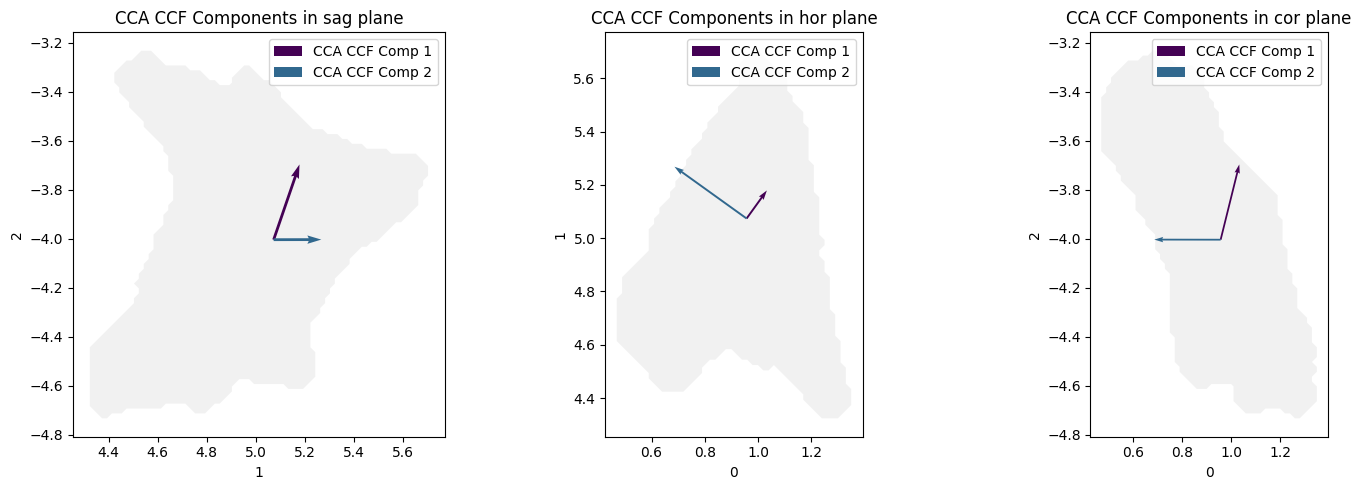

In [308]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    for c in mesh_contours[plane]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    for i in range(2):
        vec = cca_vecs[:, i].copy()
        # normalize vector for better visualization
        # vec = vec / np.linalg.norm(vec)
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_CCF_components_in_space.pdf'), bbox_inches='tight')

In [309]:
boot_yw_norm = boot_yw_aligned.copy()
# boot_yw_norm = boot_yw_aligned
origin = np.nanmean(ccf_mat, axis=0)

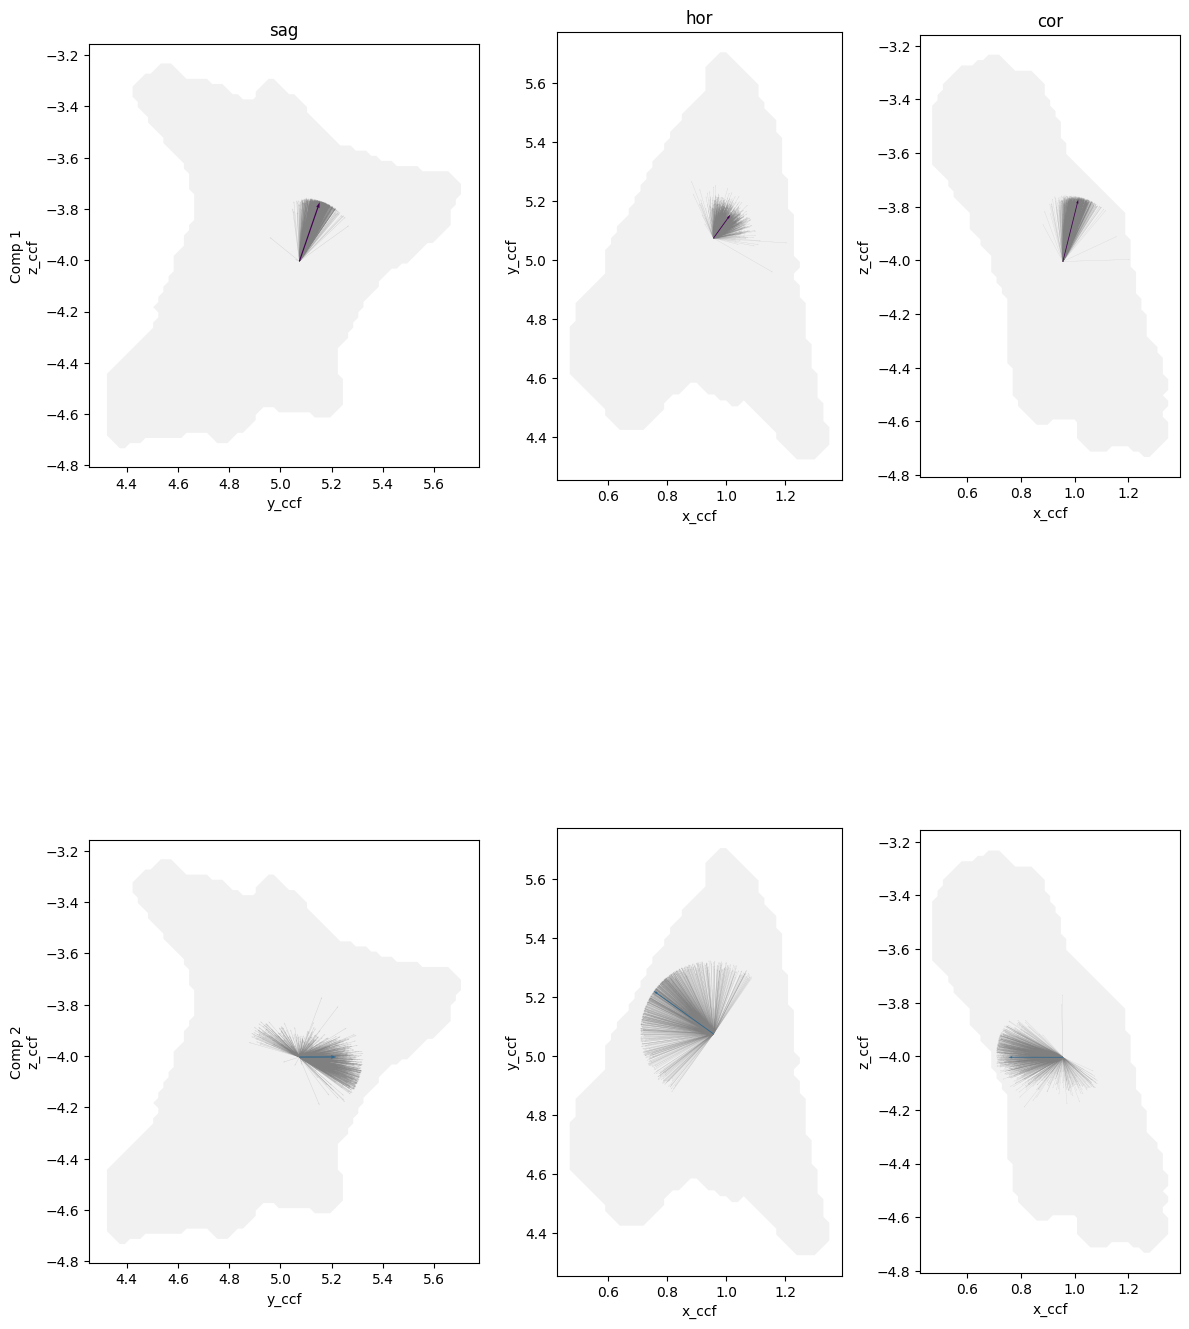

In [310]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = boot_yw_norm[b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp].copy()

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


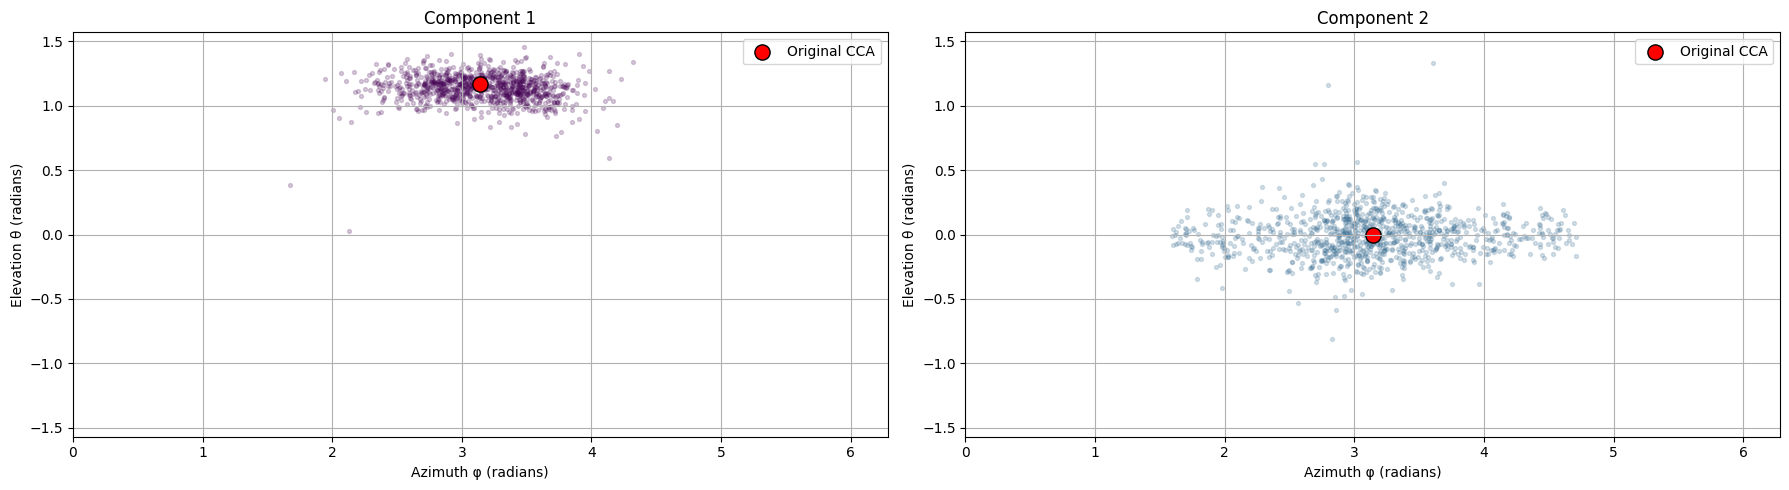

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ----- Convert vectors → spherical angles -----

# def vector_to_angles(v):
#     """Return (azimuth phi, elevation theta) for vector v."""
#     x, y, z = v
#     phi = np.arctan2(y, x)                     # horizontal angle
#     theta = np.arctan2(z, np.sqrt(x*x + y*y))  # vertical angle
#     return phi, theta


def vector_to_angles(v, off_set = 0.2):
    """Return (phi_new, theta) where φ=1 rad maps to φ_new=0."""
    x, y, z = v

    # raw azimuth φ in [0, 2π)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2 * np.pi

    # shift reference so φ=1 → φ_new=0
    phi_new = phi + off_set
    if phi_new < 0:
        phi_new += 2 * np.pi
    elif phi_new >= 2*np.pi:
        phi_new -= 2 * np.pi

    # elevation θ stays the same
    theta = np.arctan2(z, np.sqrt(x*x + y*y))

    return phi_new, theta

def express_in_basis(v, a):
    """
    Express vector v in a new coordinate system where:
      - z-axis is aligned with vector a
      - x- and y-axes are orthogonal to a (right-handed system)

    Returns:
        v_new : np.ndarray
            Coordinates of v in the new (x, y, z=a) basis
        R : np.ndarray
            3×3 rotation matrix (columns are the new basis vectors)
    """
    a = np.asarray(a, dtype=float)
    v = np.asarray(v, dtype=float)

    # Normalize z-axis (the reference direction)
    z_axis = a / np.linalg.norm(a)

    # Pick a stable arbitrary vector not parallel to z
    if abs(z_axis[0]) < 0.9:
        tmp = np.array([1, 0, 0])
    else:
        tmp = np.array([0, 1, 0])

    # Build x-axis orthogonal to z (Gram–Schmidt)
    x_axis = tmp - np.dot(tmp, z_axis) * z_axis
    x_axis /= np.linalg.norm(x_axis)

    # y-axis = z × x (right-handed system)
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Rotation matrix: columns are new basis vectors
    R = np.column_stack([x_axis, y_axis, z_axis])

    # Express v in new basis
    v_new = R.T @ v

    return v_new, R

# Compute angles for bootstrap samples
phi_boot = np.zeros((n_boot, 2))
theta_boot = np.zeros((n_boot, 2))

# Compute angles for original CCA vectors
phi_orig = np.zeros(2)
theta_orig = np.zeros(2)
comp = 0
v0 = cca_vecs[:, comp].copy()   # normalized
phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=np.pi - np.arctan2(v0[1], v0[0]))
comp = 1
v1 = cca_vecs[:, comp].copy()   # normalized
v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set= -np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)

# for component 0
comp = 0
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi - np.arctan2(v0[1], v0[0]))

# for component 1
comp = 1
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    # project v onto plane orthogonal to component 0
    v_proj, R = express_in_basis(v, cca_vecs[:, 0])
    # convert projected 2D vector to angles
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj, off_set=-np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)



# ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for comp in range(2):
    ax = axes[comp]
    
    ax.scatter(
        phi_boot[:, comp],
        theta_boot[:, comp],
        s=8, alpha=0.2,
        color=cm.viridis(comp/3)
    )
    
    # Plot original CCA direction
    ax.scatter(
        phi_orig[comp],
        theta_orig[comp],
        s=120, color='red', edgecolor='black', label='Original CCA'
    )

    ax.set_title(f'Component {comp+1}')
    ax.set_xlabel('Azimuth φ (radians)')
    ax.set_ylabel('Elevation θ (radians)')
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_direction_angle_scatter.pdf'),
            bbox_inches='tight')
plt.show()


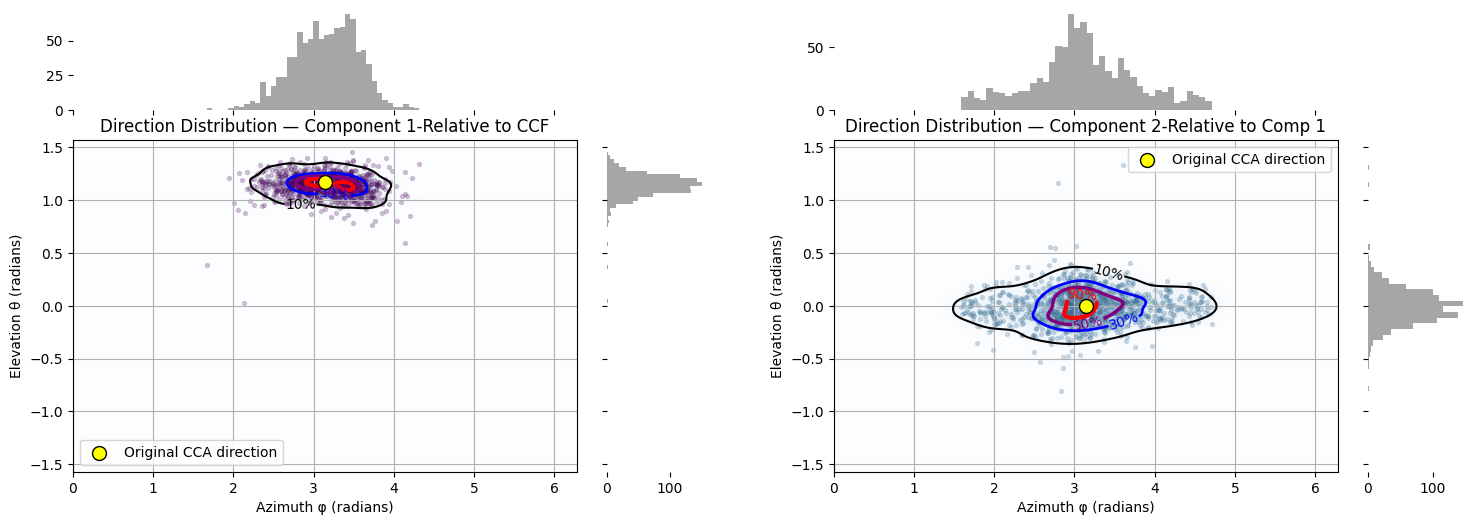

In [312]:
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kth_percentile_contour_levels(values, kde, xx, yy, levels=[0.1, 0.3, 0.5, 0.9]):
    """
    Convert percentile levels into actual KDE contour threshold values.

    Parameters
    ----------
    values : ndarray
        Flattened KDE values (e.g., kde(np.vstack([xx.ravel(), yy.ravel()]))).
    kde : gaussian_kde
        KDE object (not used in computation, kept for compatibility).
    xx, yy : ndarray
        Meshgrid arrays corresponding to evaluation grid (not used directly).
    levels : list of float
        Percentiles as fractions of total probability mass (e.g. [0.1, 0.3, 0.5, 0.9]).

    Returns
    -------
    contour_levels : list of float
        Density thresholds corresponding to requested cumulative probabilities.
    """
    # Sort KDE density values in descending order
    sorted_vals = np.sort(values)[::-1]

    # Compute normalized cumulative sum
    cumsum = np.cumsum(sorted_vals)
    cumsum /= cumsum[-1]  # normalize to 1

    contour_levels = []
    for p in levels:
        # smallest density threshold such that area above it = p
        # use interpolation for smoother results
        idx = np.searchsorted(cumsum, p)
        if idx >= len(sorted_vals):
            idx = len(sorted_vals) - 1
        contour_levels.append(sorted_vals[idx])

    return contour_levels

# -----------------------------------------------------------
# φ–θ DENSITY CONTOUR PLOT (10%, 30%, 50%, 90%) + marginals
# -----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for comp in range(2):
    ax = axes[comp]

    # KDE over φ–θ samples
    data = np.vstack([phi_boot[:, comp], theta_boot[:, comp]])
    kde = gaussian_kde(data, bw_method=0.3)

    # grid for density evaluation
    phi_grid = np.linspace(0, 2*np.pi, 300)
    theta_grid = np.linspace(-np.pi/2, np.pi/2, 300)
    xx, yy = np.meshgrid(phi_grid, theta_grid)
    zz = kde(np.vstack([xx.flatten(), yy.flatten()]))
    zz_grid = zz.reshape(xx.shape)

    # scatter bootstraps
    ax.scatter(phi_boot[:, comp], theta_boot[:, comp],
               s=8, alpha=0.2, color=cm.viridis(comp/3))

    # percentile contour levels
    contour_levels = kth_percentile_contour_levels(
        zz, kde, xx, yy, levels=[0.10, 0.30, 0.50, 0.90]
    )
    contour_levels_sorted = np.sort(contour_levels)

    # density background
    ax.imshow(
        zz_grid, origin='lower',
        extent=[0, 2*np.pi, -np.pi/2, np.pi/2],
        aspect='auto', cmap='Blues', alpha=0.3
    )

    # main contours
    cs = ax.contour(
        xx, yy, zz_grid,
        levels=contour_levels_sorted,
        colors=["black", "blue", "purple", "red"],
        linewidths=[1.5, 2.0, 2.5, 3.0]
    )
    fmt = {val: label for val, label in zip(contour_levels_sorted, ["10%", "30%", "50%", "90%"])}
    ax.clabel(cs, inline=True, fontsize=10, fmt=fmt)

    # original CCA direction
    ax.scatter(phi_orig[comp], theta_orig[comp],
               s=100, color='yellow', edgecolor='black', zorder=5,
               label="Original CCA direction")

    # axis settings
    if comp == 0:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to CCF')
    else:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to Comp 1')
    ax.set_xlabel("Azimuth φ (radians)")
    ax.set_ylabel("Elevation θ (radians)")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

    # -------------------------------------------------------
    # MARGINAL HISTOGRAMS (top and right)
    # -------------------------------------------------------
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", size=1.0, pad=0.3, sharex=ax)
    ax_histy = divider.append_axes("right", size=1.0, pad=0.3, sharey=ax)

    # Hide tick labels on hist axes
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)

    # Plot histograms
    ax_histx.hist(phi_boot[:, comp], bins=40, color='gray', alpha=0.7)
    ax_histy.hist(theta_boot[:, comp], bins=40, orientation='horizontal', color='gray', alpha=0.7)

    # Match limits
    ax_histx.set_xlim(ax.get_xlim())
    ax_histy.set_ylim(ax.get_ylim())

    # Simplify look
    for spine in ax_histx.spines.values():
        spine.set_visible(False)
    for spine in ax_histy.spines.values():
        spine.set_visible(False)

# plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_direction_angle_density_contours_with_marginals.pdf'),
    bbox_inches='tight'
)
plt.show()

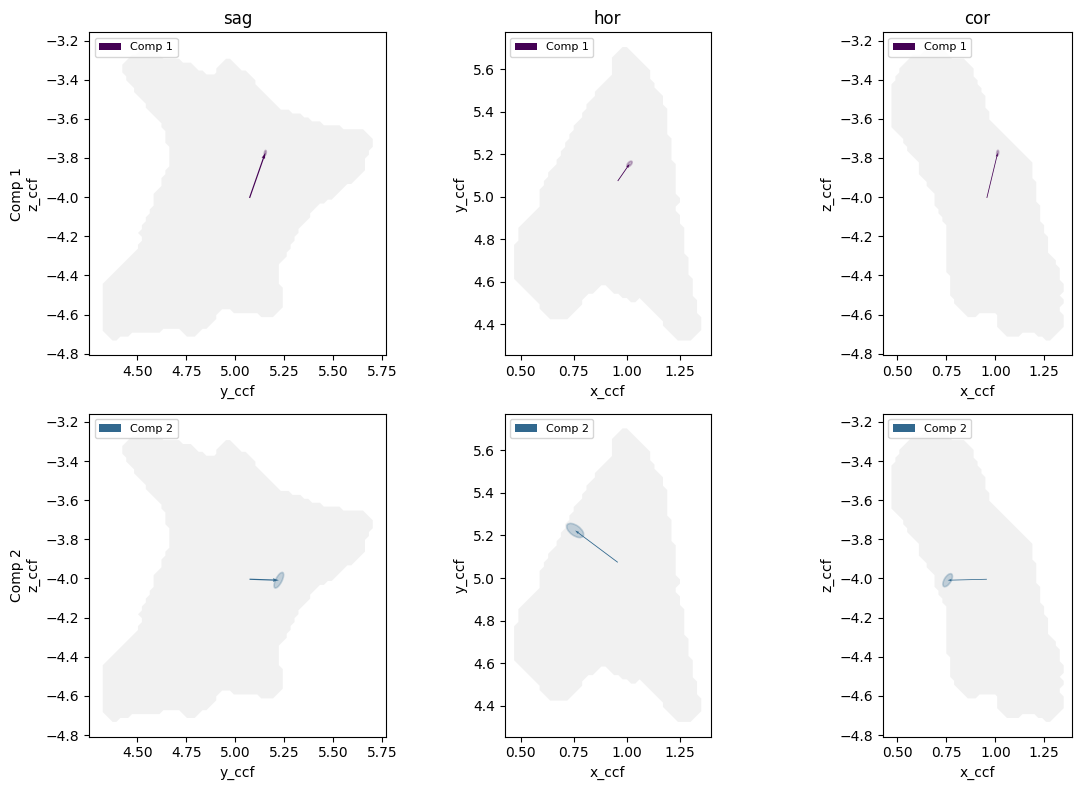

In [313]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw_norm[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = 1/0.25  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)

        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap_{n_se}_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


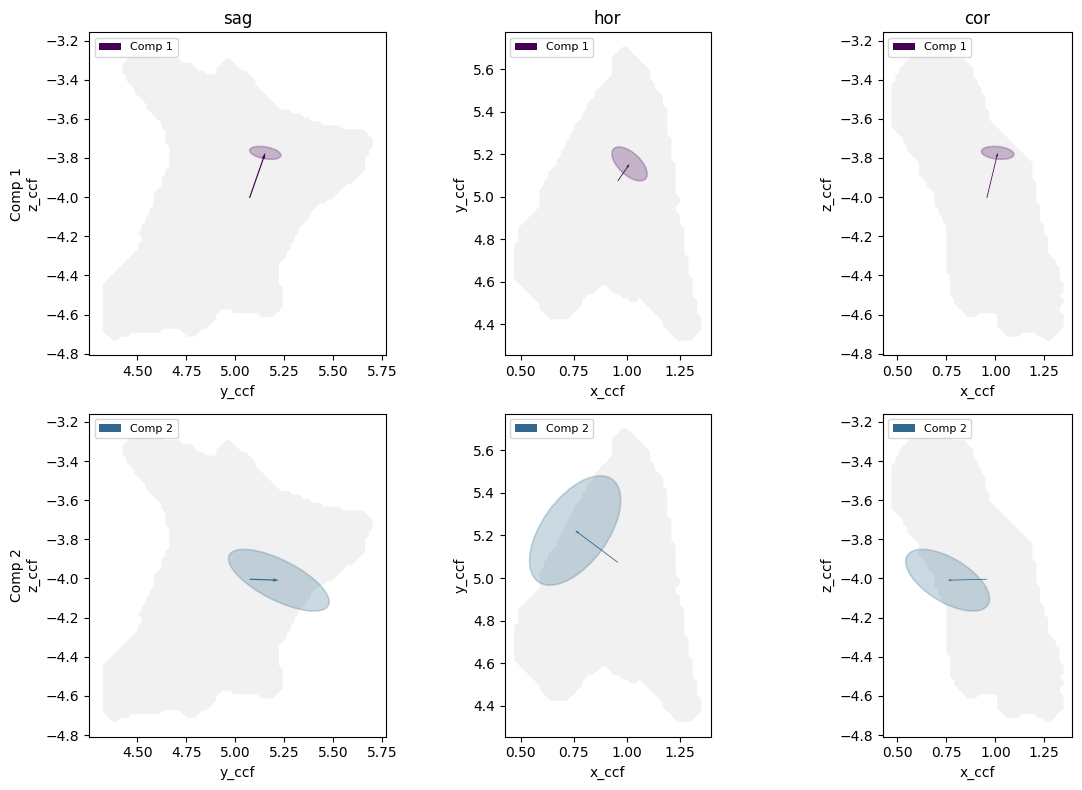

In [314]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
ci = 0.95
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        from scipy.stats import chi2
        # central 90% CI == 5% to 95%
        chi2_val = chi2.ppf(ci, df=2) # 2D chi-square quantile
        scale_ci = np.sqrt(chi2_val)

        boot_vecs = boot_yw_norm[:, :, comp]  # (n_boot, 3)
        # normalize each bootstrap vector (important if not already)
        boot_vecs = boot_vecs / np.linalg.norm(boot_vecs, axis=1, keepdims=True)

        # Mean vector (unit norm)
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # 2D projected direction (unit norm in 3D; 2D length varies)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        scale = 1/0.25  # your arrow scaling factor

        # --- Work in endpoint space (matches what you plot) ---
        endpts = np.column_stack([
            origin[ix] + vecs_2d[:, 0] / scale,
            origin[iy] + vecs_2d[:, 1] / scale,
        ])

        # Center ellipse at the mean endpoint
        end_mean = np.array([
            origin[ix] + mean_2d[0] / scale,
            origin[iy] + mean_2d[1] / scale,
        ])

        # Covariance of endpoints (NOT divided by n_boot)
        cov = np.cov(endpts.T)

        # Eigen-decomposition for ellipse axes
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # Ellipse parameters for 90% CI
        width, height = 2 * scale_ci * np.sqrt(eigvals)  # factor 2 because width/height are full lengths
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        ellipse = Ellipse(
            xy=end_mean,
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)


        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap_{ci}%_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


/tmp/ipykernel_393995/949386485.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')
/tmp/ipykernel_393995/949386485.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')


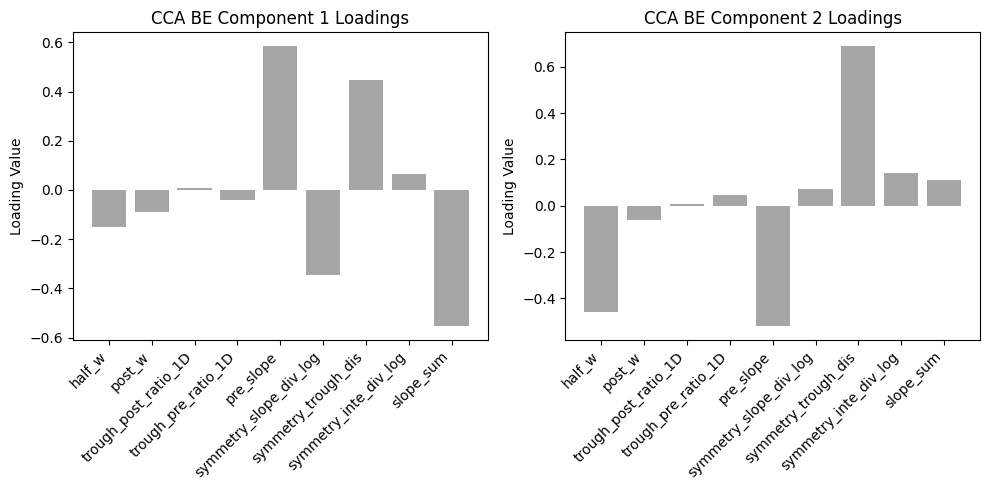

In [315]:
cca_be_coeff = cca.x_weights_.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax = axes[i]
    ax.bar(focus_features_cca, cca.x_weights_[:, i], color='gray', alpha=0.7)
    ax.set_title(f'CCA BE Component {i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'CCA_wf_components_loadings.pdf'), bbox_inches='tight')

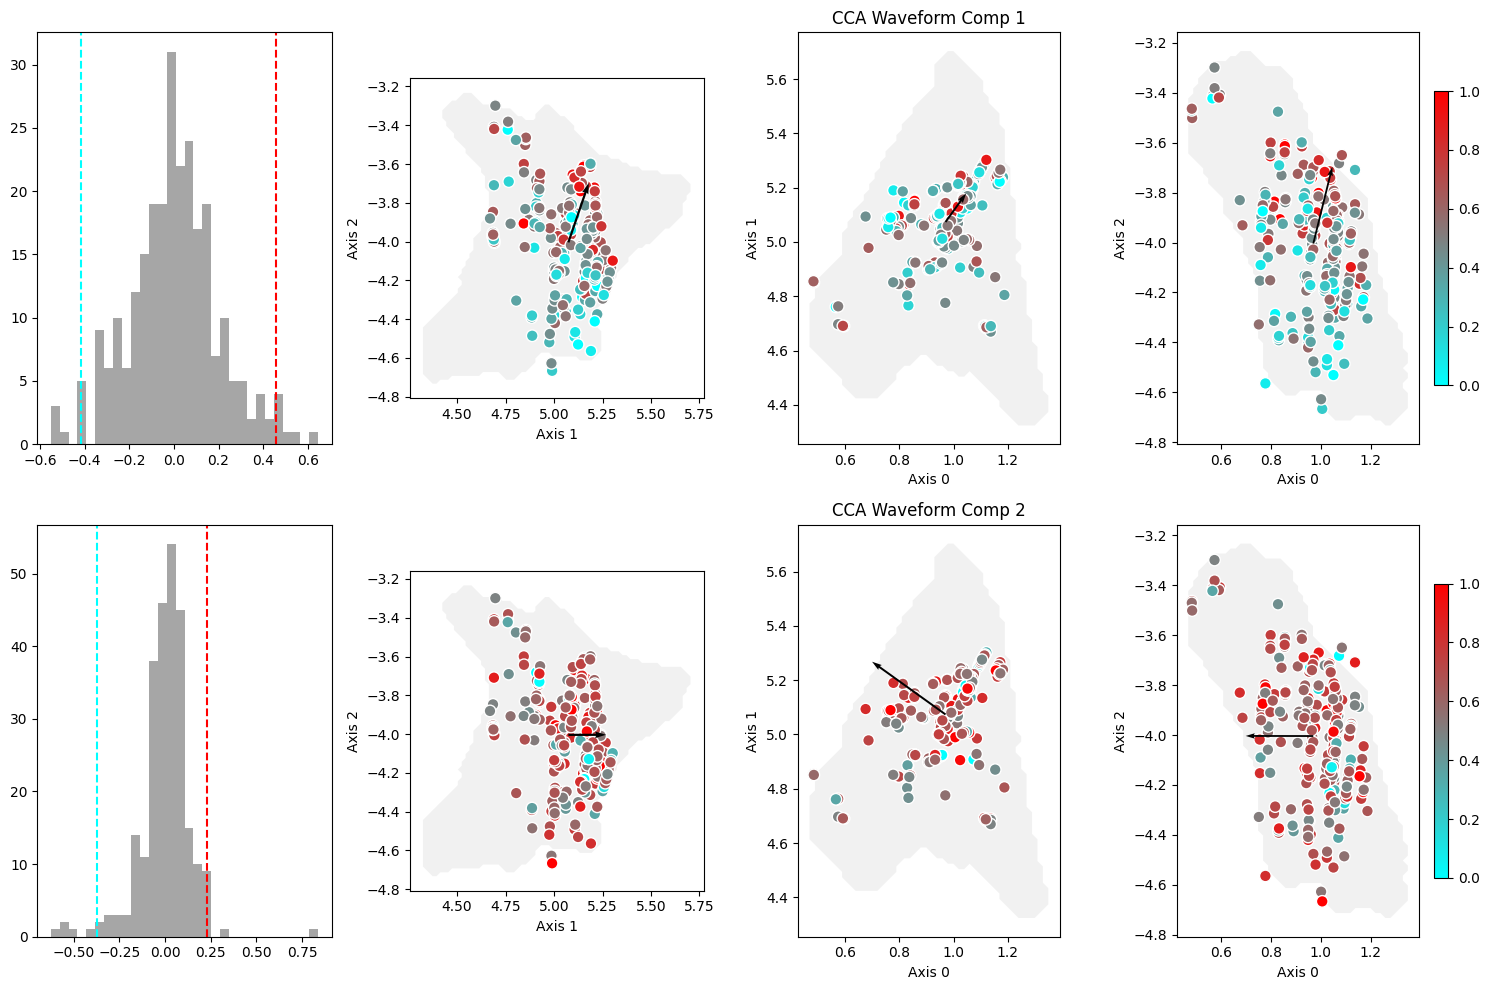

In [370]:

from scipy.ndimage import binary_dilation

# -------------------------------------------------------------------------
# Helper: project 3D mesh to 2D contours
# -------------------------------------------------------------------------
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (0, 1, 1)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (1, 0, 0))])

# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# CCF coordinates and planes
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

for dim_ind in range(2):
    cca_values = cca_result_be[:, dim_ind].copy()

    # Clip and normalize color values
    low, high = np.nanquantile(cca_values, [0.02, 0.98])
    cca_values_nl = np.clip(cca_values, low, high)
    cca_values_nl = (cca_values_nl - low) / (high - low)
    # cca_values_nl[np.isnan(cca_values_nl)] = 0.0
    # rank it
    # cca_values_nl = rankdata(cca_values_nl) / len(cca_values_nl)
    ax = axes[dim_ind, 0]
    ax.hist(cca_values, bins=30, color='gray', alpha=0.7)
    ax.axvline(low, linestyle='--', label='bottom', color=custom_cmap(0.00000001))
    ax.axvline(high, linestyle='--', label='top', color=custom_cmap(0.99999999))
    sort_ind = np.argsort(cca_values_nl)
    # randomize order within ties
    sort_ind = np.random.permutation(sort_ind)

    for j, (plane_name, plane_axes) in enumerate(planes.items()):
        ax = axes[dim_ind, j+1]

        # --- fill mesh projection contours ---
        for c in mesh_contours[plane_name]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # --- scatter of projected CCF points ---
        proj_ccf = ccfs[:, plane_axes]
        sc = ax.scatter(
            proj_ccf[sort_ind, 0], proj_ccf[sort_ind, 1],
            c=cca_values_nl[sort_ind], cmap=custom_cmap,
            s = 70, edgecolor='white', alpha=1, linewidth=1
        )

        # --- plot CCA direction vector ---
        vec = cca_vecs[:, dim_ind].copy()
        origin = np.nanmean(ccfs, axis=0)
        ax.quiver(origin[plane_axes[0]], origin[plane_axes[1]],
                  vec[plane_axes[0]], vec[plane_axes[1]],
                  angles='xy', scale_units='xy', scale=3,
                  color='k', label=f'CCA CCF Comp {dim_ind+1}')

        if plane_name == 'hor':
            ax.set_title(f'CCA Waveform Comp {dim_ind+1}')
        ax.set_xlabel(f'Axis {plane_axes[0]}')
        ax.set_ylabel(f'Axis {plane_axes[1]}')
        ax.set_aspect('equal')

        if plane_name == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'cca_1&2_waveform_components_in_space.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'cca_1&2_waveform_components_in_space.svg'),
            dpi=300, bbox_inches='tight')
plt.show()


In [368]:
custom_cmap(0.000001), custom_cmap(0.5), custom_cmap(0.999999)

((np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)),
 (np.float64(0.5019607843137255),
  np.float64(0.4980392156862745),
  np.float64(0.4980392156862745),
  np.float64(1.0)),
 (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0)))

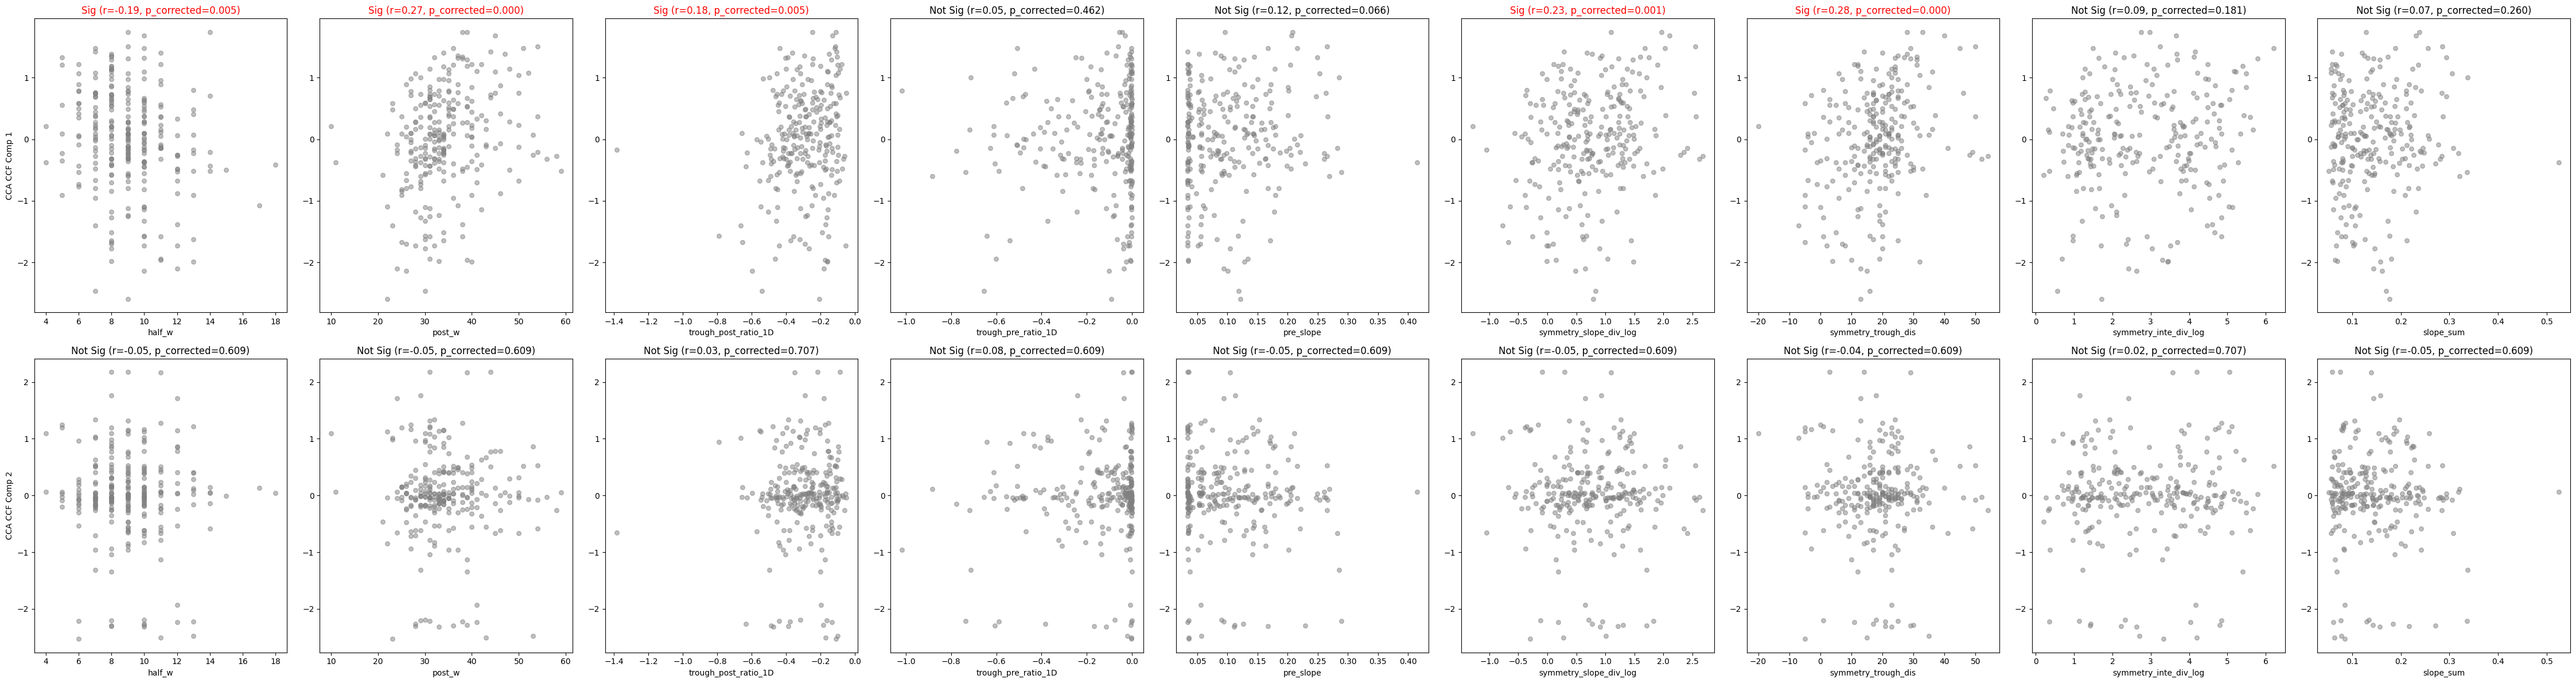

In [317]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# --- create figure with 3 rows (CCA components) and one column per feature ---
fig, axes = plt.subplots(2, len(focus_features_cca), figsize=(5*len(focus_features_cca), 12))

for j in range(2):  # iterate over CCA components
    cca_ccf_values = cca_result_ccf[:, j].copy()
    all_p = []
    all_coef = []
    for i, feature in enumerate(focus_features_cca):
        ax = axes[j, i]
        feature_values = combined_features[feature].values[filter][~nan_ind_cca]

        # scatter plot
        ax.scatter(feature_values, cca_ccf_values, c='gray', alpha=0.5, s=30)
        ax.set_xlabel(feature)
        if i == 0:
            ax.set_ylabel(f'CCA CCF Comp {j+1}')

        # compute correlation
        corr_coef, p_value = pearsonr(feature_values, cca_ccf_values)
        all_p.append(p_value)
        all_coef.append(corr_coef)

    # adjust for multiple comparisons 
    reject, pvals_corrected, _, _ = multipletests(all_p, method='fdr_bh', alpha=0.05)
    for i, ax in enumerate(axes[j, :]):
        if reject[i]:
            ax.set_title(f'Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='red')
        else:
            ax.set_title(f'Not Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='black')



plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_beh_CCF_scatter_by_component.pdf'),
    bbox_inches='tight', dpi=300
)
plt.show()

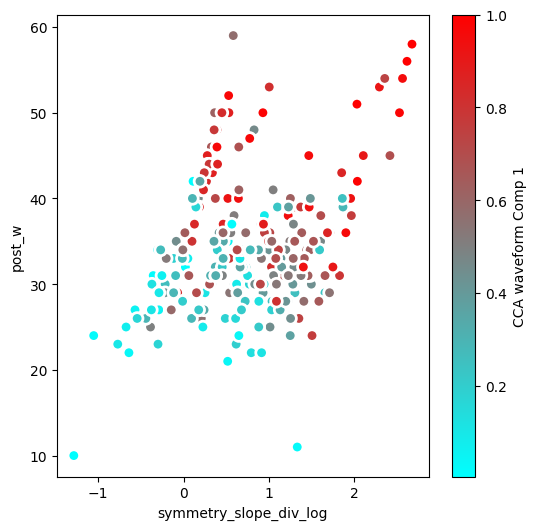

In [318]:
fig = plt.figure(figsize=(6, 6))
x_val = 'symmetry_slope_div_log'
y_val = 'post_w'
x = combined_features[x_val][filter][~nan_ind_cca]
# add a bit noise
# x = x + np.random.normal(0, 0.01, size=x.shape)
# y = np.log(-combinedf_features['post_slope']+0.00001)[~nan_ind_cca]
y = combined_features[y_val][filter][~nan_ind_cca]
color_code = cca_result_be[:, 0]
color_code = rankdata(color_code) / len(color_code)
sc = plt.scatter(x, y, c = color_code, cmap = custom_cmap, alpha = 1, edgecolor = 'white', s = 70, linewidths= 2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.colorbar(sc, label='CCA waveform Comp 1')
plt.savefig(os.path.join(target_folder, f'{y_val}_vs_{x_val}_cca_comp1.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(wf_folder, f'cca_behavioral_comp1_vs_postw_symmslope.svg'), dpi=300, bbox_inches='tight')

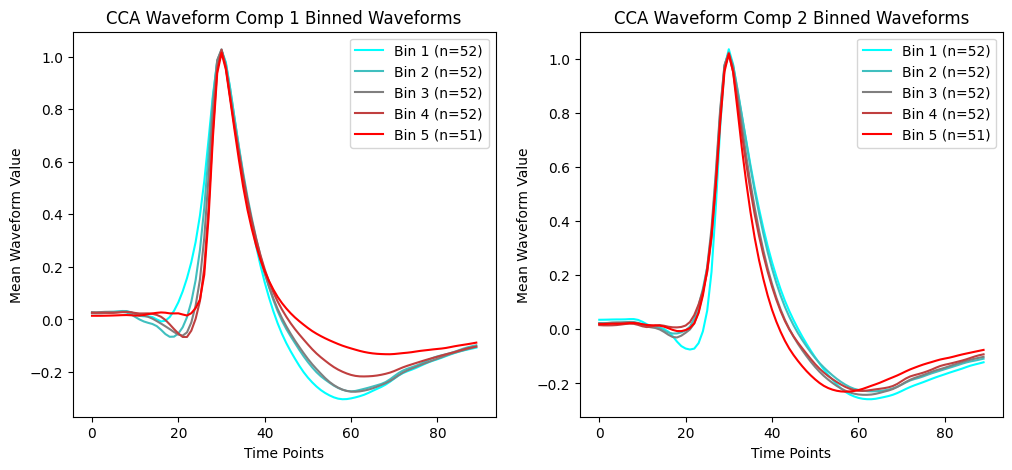

In [319]:
# binned waveform by cca1 and 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
n_bins = 5
for i in range(2):
    ax = axes[i]
    cca_values = cca_result_be[:, i].copy()
    bins = np.quantile(cca_values, np.linspace(0, 1, n_bins+1))
    bin_indices = np.digitize(cca_values, bins) - 1  # bin indices from 0 to n_bins-1
    for b in range(n_bins):
        idx = bin_indices == b
        if np.sum(idx) > 0:
            mean_waveform = np.nanmean(waveforms[idx], axis=0)
            ax.plot(mean_waveform, label=f'Bin {b+1} (n={np.sum(idx)})', c = custom_cmap(b / (num_bins - 1)))
    ax.set_title(f'CCA Waveform Comp {i+1} Binned Waveforms')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Mean Waveform Value')
    ax.legend()

# Shuffling

In [320]:
# create a functions that takes in cca_be_mat and ccf_mat and performs the entire cca with bootstrap and returns the cca results with ci
# outputs: cca_result_be, cca_result_ccf, xw_low, xw_high, yw_low, yw_high, boot_xw, boot_yw, cca_x_weights, cca_y_weights
from collections import defaultdict
def perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05, return_all=False):
    # Fit original CCA
    cca = CCA(n_components=2)
    cca.fit(cca_be_mat, ccf_mat)
    xw = cca.x_weights_
    yw = cca.y_weights_

    cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

    cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)

    # Bin data into 3D voxels
    coords = ccf_mat
    n_bins_xyz = (3, 3, 4)
    bins = [
        np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
        for i in range(3)
    ]
    xbin = np.digitize(coords[:, 0], bins[0]) - 1
    ybin = np.digitize(coords[:, 1], bins[1]) - 1
    zbin = np.digitize(coords[:, 2], bins[2]) - 1

    voxel_map = defaultdict(list)
    for i in range(len(coords)):
        v = (xbin[i], ybin[i], zbin[i])
        voxel_map[v].append(i)

    valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]
    counts = np.array([len(voxel_map[v]) for v in valid_voxels])
    total_count = counts.sum()
    samples_per_voxel = np.maximum(1, np.floor((counts / total_count) * n_samples).astype(int))

    # Bootstrap loop
    rng = np.random.default_rng(4)
    boot_xw = np.zeros((n_boot, cca_be_mat.shape[1], 2))
    boot_yw = np.zeros((n_boot, 3, 2))

    for b in range(n_boot):
        indices = []
        for vox_idx, voxel in enumerate(valid_voxels):
            n_draw = voxel_map[voxel].__len__()
            picked = rng.choice(
                voxel_map[voxel],
                size=n_draw,
                replace=True
            )
            indices.extend(picked)
        indices = np.array(indices)
        Xb = cca_be_mat[indices]
        Yb = ccf_mat[indices]
        cca_b = CCA(n_components=2)
        cca_b.fit(Xb, Yb)
        boot_xw[b] = cca_b.x_weights_
        boot_yw[b] = cca_b.y_weights_
        # for comp in range(2):
        #     xw = cca_b.x_weights_[:, comp]
        #     yw = cca_b.y_weights_[:, comp]
        #     xw /= np.linalg.norm(xw)
        #     yw /= np.linalg.norm(yw)
        #     boot_xw[b, :, comp] = xw
        #     boot_yw[b, :, comp] = yw
        # xw = cca_b.x_weights_[:, 0]
        # yw = cca_b.y_weights_[:, 0]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 0] = xw
        # boot_yw[b, :, 0] = yw
        # # # second component (optional)
        # xw = cca_b.x_weights_[:, 1]
        # yw = cca_b.y_weights_[:, 1]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 1] = xw
        # boot_yw[b, :, 1] = yw
        # Xb_res = Xb - (Xb @ xw[:, 0][:, None]) * xw[:, 0][None, :]
        # Yb_res = Yb - (Yb @ yw[:, 0][:, None]) * yw[:, 0][None, :]
        # cca_b2 = CCA(n_components=1)
        # cca_b2.fit(Xb_res, Yb_res)
        # xw_2 = cca_b2.x_weights_[:, 0]
        # yw_2 = cca_b2.y_weights_[:, 0]
        # boot_xw[b, :, 1] = xw_2
        # boot_yw[b, :, 1] = yw_2
    # Sign alignment
    boot_yw_aligned = boot_yw.copy()
    boot_xw_aligned = boot_xw.copy()

    boot_yw_norm = (
        boot_yw_aligned /
        np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
    )

    for comp in range(2):
        ref = cca_vecs[:, comp]
        for b in range(n_boot):
            if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
                boot_yw_aligned[b, :, comp] *= -1
                boot_xw_aligned[b, :, comp] *= -1




    boot_yw = boot_yw_aligned
    boot_xw = boot_xw_aligned

    boot_yw = (
        boot_yw /
        np.linalg.norm(boot_yw, axis=1, keepdims=True)
    )

    # compute CI bounds
    xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
    xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)
    yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
    yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

    # save correlation of cca results
    corrs = np.corrcoef(cca_result_be.T, cca_result_ccf.T)
    corrs = np.diag(corrs[:2, 2:])

    # Compute angles 
    phi_boot = np.zeros((n_boot, 2))
    theta_boot = np.zeros((n_boot, 2))
    # mean vector
    v_mean = np.nanmean(boot_yw, axis=0)
    ang_mean_0 = np.arctan2(v_mean[1, 0], v_mean[0, 0])
    # ang_mean_1 = np.arctan2(v_mean[1, 1], v_mean[0, 1])
    # for comp 0
    comp = 0
    for b in range(n_boot):
        v = boot_yw[b, :, comp]
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi-ang_mean_0)
    # for comp 1
    comp = 1
    v_proj = np.zeros((n_boot, 3))
    for b in range(n_boot):
        # project v onto plane orthogonal to component 0
        v_proj[b, :], R = express_in_basis(boot_yw[b, :, comp], cca_vecs[:, 0])
        # convert projected 2D vector to angles
    # mean vector
    v_mean_1 = np.nanmean(v_proj, axis=0)
    ang_mean_1 = np.arctan2(v_mean_1[1], v_mean_1[0])
    for b in range(n_boot):
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj[b, :], off_set=np.pi - ang_mean_1)

    # compute angles for original CCA vectors
    phi_orig = np.zeros(2)
    theta_orig = np.zeros(2)
    # for comp 0
    comp = 0
    v0 = cca_vecs[:, comp]   # normalized
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=-0.5)
    # for comp 1
    comp = 1
    v1 = cca_vecs[:, comp]
    v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set=1)


    # variance for directions:
    cov_matrix_comp0 = np.cov((boot_yw[:, :, 0]).T)
    cov_matrix_comp1 = np.cov((boot_yw[:, :, 1]).T)
    # eigen decomposition
    eigvals_vec_0, eigvecs_vec_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_vec_0)
    principal_dir0_vec = eigvecs_vec_0[:, max_idx0]
    principal_var0_vec = eigvals_vec_0[max_idx0]

    eigvals_vec_1, eigvecs_vec_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_vec_1)
    principal_dir1_vec = eigvecs_vec_1[:, max_idx1]
    principal_var1_vec = eigvals_vec_1[max_idx1]

    # variance for angles:
    # calcuate covariance of phi and theta
    cov_matrix_comp0 = np.cov(theta_boot[:, 0], phi_boot[:, 0])
    cov_matrix_comp1 = np.cov(theta_boot[:, 1], phi_boot[:, 1])
    # eigen decomposition
    # For component 0
    eigvals_ang_0, eigvecs_ang_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_ang_0)
    principal_dir0_ang = eigvecs_ang_0[:, max_idx0]
    principal_var0_ang = eigvals_ang_0[max_idx0]

    # For component 1
    eigvals_ang_1, eigvecs_ang_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_ang_1)
    principal_dir1_ang = eigvecs_ang_1[:, max_idx1]
    principal_var1_ang = eigvals_ang_1[max_idx1]
    result = {'corrs': corrs,
                # 'cca_result_be': cca_result_be,
                # 'cca_result_ccf': cca_result_ccf,
                # 'xw_low': xw_low,
                # 'xw_high': xw_high,
                # 'yw_low': yw_low,
                # 'yw_high': yw_high,
                # 'boot_xw': boot_xw,
                # 'boot_yw': boot_yw,
                'cca_x_weights': cca.x_weights_,
                'cca_y_weights': cca.y_weights_,
                'cca_vecs': cca_vecs,
                # 'phi_boot': phi_boot,
                # 'theta_boot': theta_boot,
                'phi_orig': phi_orig,
                'theta_orig': theta_orig,
                # 'var_phi': var_phi,
                # 'var_theta': var_theta,
                'eigvals_vec_0': np.sort(eigvals_vec_0)[::-1],
                # 'eigvecs_vec_0': eigvecs_vec_0,
                'eigvals_vec_1': np.sort(eigvals_vec_1)[::-1], 
                # 'eigvecs_vec_1': eigvecs_vec_1,
                'eigvals_ang_0': np.sort(eigvals_ang_0)[::-1],
                # 'eigvecs_ang_0': eigvecs_ang_0,
                'eigvals_ang_1': np.sort(eigvals_ang_1)[::-1],
                # 'eigvecs_ang_1': eigvecs_ang_1,
                }
    if not return_all:
        return result
    else:
        result.update({
            'boot_xw': boot_xw,
            'boot_yw': boot_yw,
            'phi_boot': phi_boot,
            'theta_boot': theta_boot,
        })
        return result
        
        
def shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05):
    # shuffle the cca_be_mat
    shuffled_cca_be_mat = cca_be_mat.copy()
    np.random.shuffle(shuffled_cca_be_mat)
    # perform cca with bootstrap
    results = perform_cca_with_bootstrap(shuffled_cca_be_mat, ccf_mat, n_samples, n_boot, alpha, return_all=False)
    return results

In [321]:

# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = combined_features['isi_violations'] < 0.5
cca_be_mat = combined_features[focus_features].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
result_ori = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05, return_all=True)
# result = shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=1000, n_boot=1000, alpha=0.05)

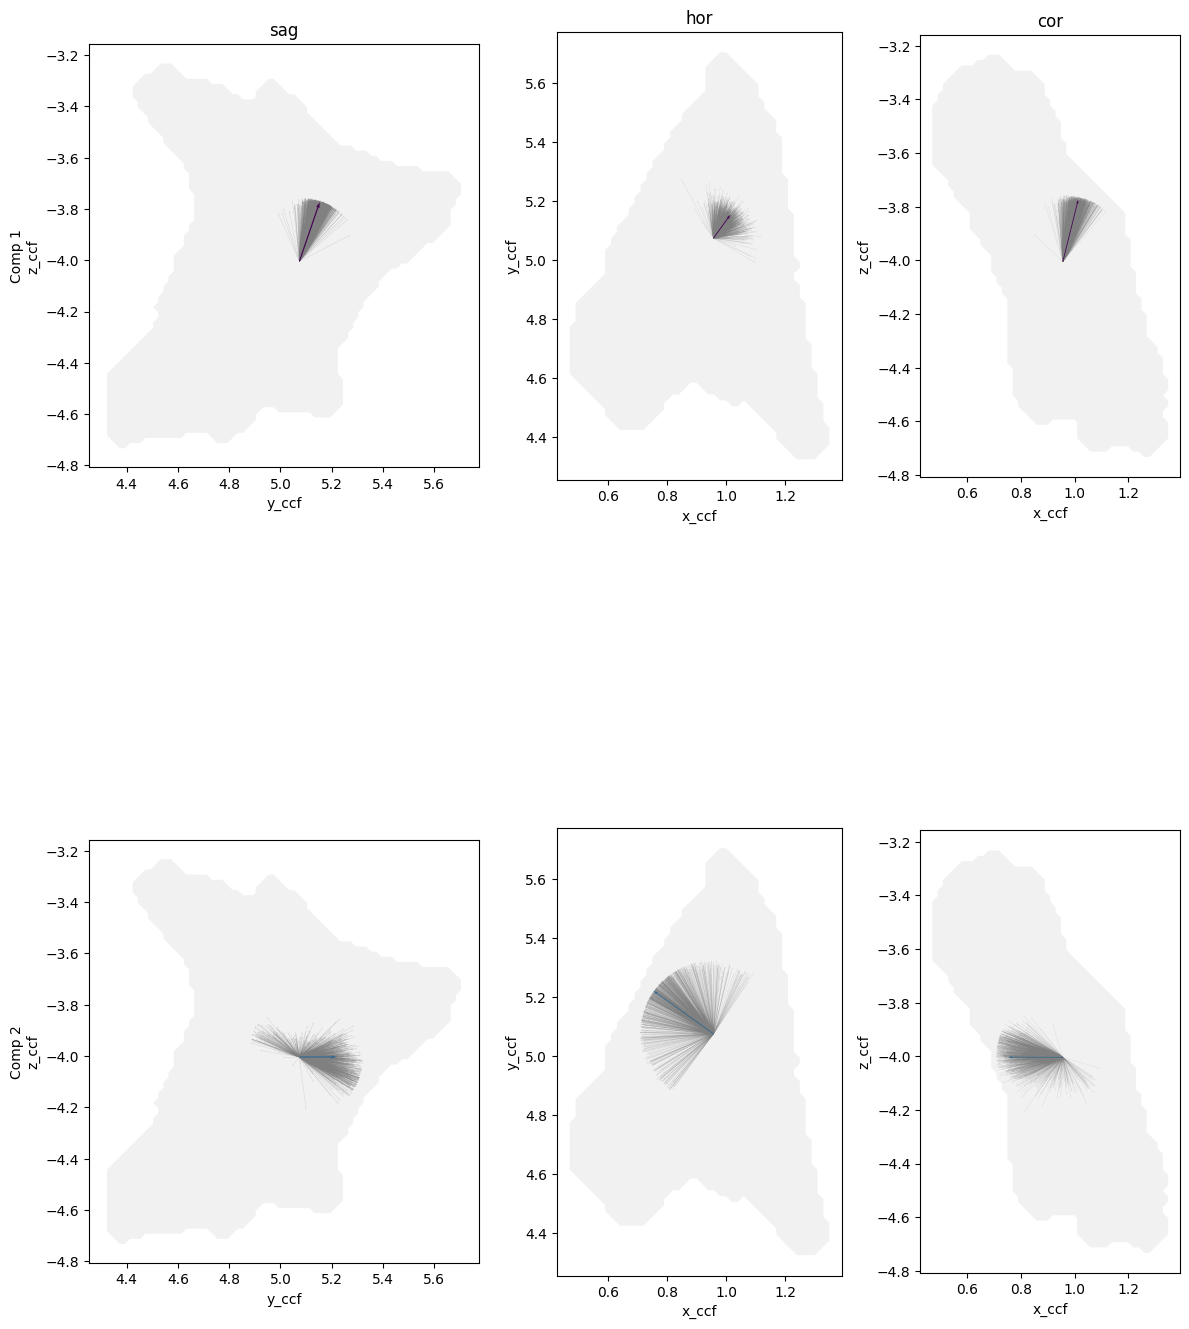

In [322]:
# Plot
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = result_ori['boot_yw'][b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


In [323]:
from joblib import Parallel, delayed
parallel_results = Parallel(n_jobs=10)(
    delayed(shuffle_cca_with_bootstrap)(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05)
    for _ in range(500)
)

KeyboardInterrupt: 

In [ ]:
# make results into df
shuffle_eigvals_vec_0 = np.array([res['eigvals_vec_0'] for res in parallel_results])
shuffle_eigvals_vec_1 = np.array([res['eigvals_vec_1'] for res in parallel_results])
shuffle_eigvals_ang_0 = np.array([res['eigvals_ang_0'] for res in parallel_results])
shuffle_eigvals_ang_1 = np.array([res['eigvals_ang_1'] for res in parallel_results])
shuffle_corr_0 = np.array([res['corrs'][0] for res in parallel_results])
shuffle_corr_1 = np.array([res['corrs'][1] for res in parallel_results])
import pandas as pd
shuffle_results_df = pd.DataFrame({
    'eigvals_vec_0_1': shuffle_eigvals_vec_0[:, 0],
    'eigvals_vec_0_2': shuffle_eigvals_vec_0[:, 1],
    'eigvals_vec_1_1': shuffle_eigvals_vec_1[:, 0],
    'eigvals_vec_1_2': shuffle_eigvals_vec_1[:, 1],
    'eigvals_ang_0_1': shuffle_eigvals_ang_0[:, 0],
    'eigvals_ang_0_2': shuffle_eigvals_ang_0[:, 1],
    'eigvals_ang_1_1': shuffle_eigvals_ang_1[:, 0],
    'eigvals_ang_1_2': shuffle_eigvals_ang_1[:, 1],
    'corr_0': shuffle_corr_0,
    'corr_1': shuffle_corr_1
})


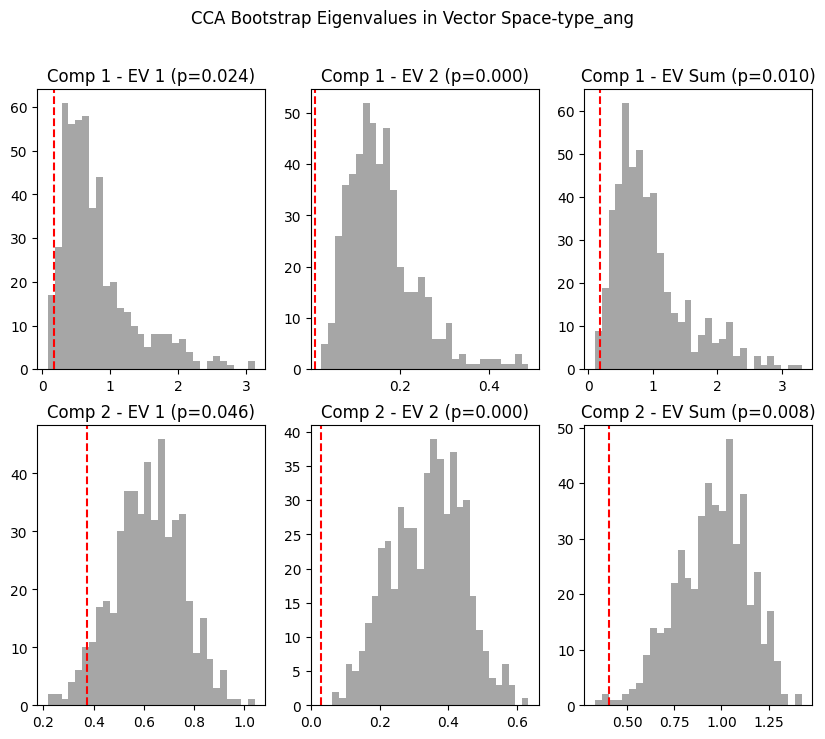

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
# Plot eigenvalue distributions for vector space
type = 'ang'
for comp in range(2):
    for eigen_int in range(2):
        ax = axes[comp, eigen_int]
        ax.hist(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'],
            bins=30, color='gray', alpha=0.7
        )
        ax.axvline(
            x=result_ori[f'eigvals_{type}_{comp}'][eigen_int],
            color='red', linestyle='--',
            label='Original CCA'
        )
        p_value = np.mean(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'] <=
            result_ori[f'eigvals_{type}_{comp}'][eigen_int]
        )
        ax.set_title(f'Comp {comp+1} - EV {eigen_int+1} (p={p_value:.3f})')
    eigen_sum = result_ori[f'eigvals_{type}_{comp}'].sum()
    eigen_sum_shuffle = shuffle_results_df[[f'eigvals_{type}_{comp}_1', f'eigvals_{type}_{comp}_2']].sum(axis=1)
    p_value = np.mean(eigen_sum_shuffle <= eigen_sum)
    axes[comp, 2].hist(
        eigen_sum_shuffle,
        bins=30, color='gray', alpha=0.7
    )
    axes[comp, 2].axvline(
        x=eigen_sum,
        color='red', linestyle='--',
        label='Original CCA'
    )
    axes[comp, 2].set_title(f'Comp {comp+1} - EV Sum (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Eigenvalues in Vector Space-type_{type}')
# plt.sca(axes[0, 0])
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_variance_by_eigenvalues_{type}.pdf'),
    bbox_inches='tight'
)

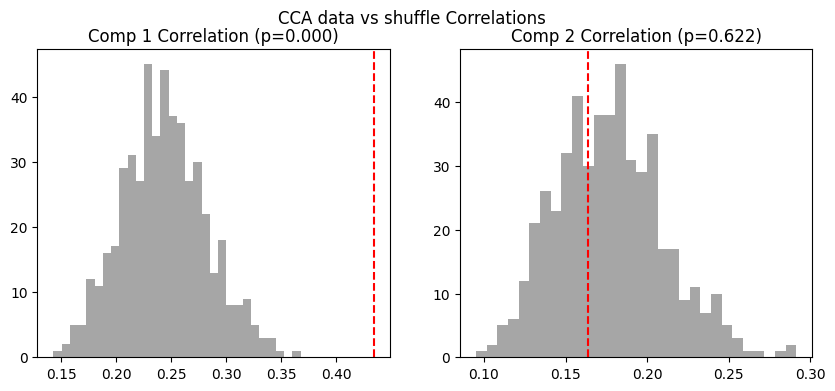

In [ ]:
# plot the same for corr
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for comp in range(2):
    ax = axes[comp]
    ax.hist(
        shuffle_results_df[f'corr_{comp}'],
        bins=30, color='gray', alpha=0.7
    )
    ax.axvline(
        x=result_ori['corrs'][comp],
        color='red', linestyle='--',
        label='Original CCA'
    )
    p_value = np.mean(
        shuffle_results_df[f'corr_{comp}'] >=
        result_ori['corrs'][comp]
    )
    ax.set_title(f'Comp {comp+1} Correlation (p={p_value:.3f})')
plt.suptitle(f'CCA data vs shuffle Correlations')
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_correlation.pdf'),
    bbox_inches='tight'
)

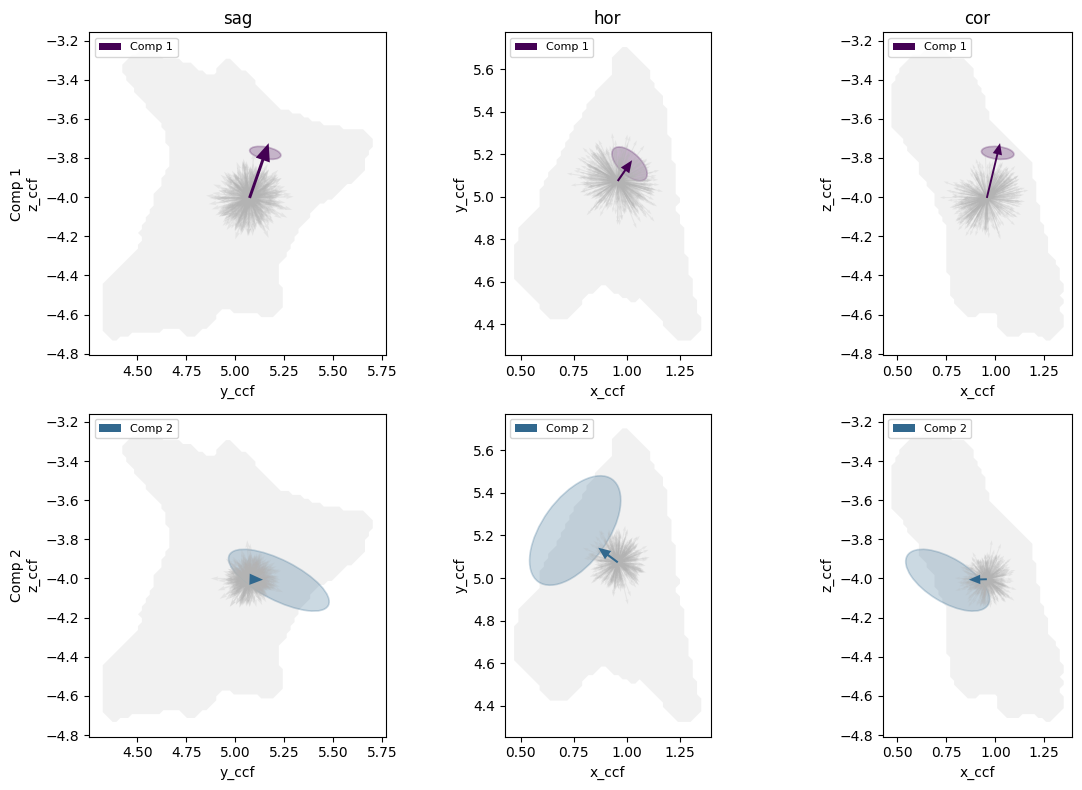

In [ ]:
# plot shuffled cca vectors in 2D planes with cones
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

boot_yw = result_ori['boot_yw']
boot_yw = boot_yw / np.linalg.norm(boot_yw, axis=1, keepdims=True)

n_boot = boot_yw.shape[0]

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
ci = 0.95
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # ----------------------------
        from scipy.stats import chi2
        # central 90% CI == 5% to 95%
        chi2_val = chi2.ppf(ci, df=2) # 2D chi-square quantile
        scale_ci = np.sqrt(chi2_val)

        boot_vecs = boot_yw_norm[:, :, comp]  # (n_boot, 3)
        # normalize each bootstrap vector (important if not already)
        boot_vecs = boot_vecs / np.linalg.norm(boot_vecs, axis=1, keepdims=True)

        # Mean vector (unit norm)
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # 2D projected direction (unit norm in 3D; 2D length varies)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        scale = 1/0.25  # your arrow scaling factor

        # --- Work in endpoint space (matches what you plot) ---
        endpts = np.column_stack([
            origin[ix] + vecs_2d[:, 0] / scale,
            origin[iy] + vecs_2d[:, 1] / scale,
        ])

        # Center ellipse at the mean endpoint
        end_mean = np.array([
            origin[ix] + mean_2d[0] / scale,
            origin[iy] + mean_2d[1] / scale,
        ])

        # Covariance of endpoints (NOT divided by n_boot)
        cov = np.cov(endpts.T)

        # Eigen-decomposition for ellipse axes
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # Ellipse parameters for 90% CI
        width, height = 2 * scale_ci * np.sqrt(eigvals)  # factor 2 because width/height are full lengths
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        ellipse = Ellipse(
            xy=end_mean,
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)



        # ----------------------------
        # All shuffle vectors (transparent)
        # ----------------------------
        for shu in parallel_results:
            shu_vec = shu['cca_y_weights'][:, comp]
            shu_vec /= np.linalg.norm(shu_vec)
            scale = (1/(shu['corrs'][comp]))*1/0.7
            ax.quiver(
                origin[ix], origin[iy],
                shu_vec[ix], shu_vec[iy],
                angles='xy', scale_units='xy', scale=scale,
                color=[0.7, 0.7, 0.7],
                alpha=0.2,
                width=0.005,
                linewidth=0.01
            )
        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.01,            # ⬅️ thicker arrow shaft (was 0.004)
            linewidth=1.5,         # ⬅️ slightly heavier outline
            headwidth=5,          # ⬅️ makes arrowhead wider
            headlength=6,         # ⬅️ makes arrowhead longer
            headaxislength=6,     # ⬅️ makes axis-aligned portion of head larger
            label=f'Comp {comp+1}'
        )


        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, f'CCA_CCF_components_bootstrap&shuffle_CI_{ci}_cones.pdf'),
    bbox_inches='tight'
)
plt.show()
